# Electric Vehicle in Washington State: 1. EDA and Data Preprocessing

In [1]:
import pickle
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import re
import time
import requests
from tqdm import tqdm
from joblib import Parallel, delayed

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler

In [3]:
from IPython.display import display, HTML

def print_all(df): 
    with pd.option_context('display.max_rows',None):
        with pd.option_context('display.max_columns',None):
            with pd.option_context('display.float_format', '{:,.4f}'.format):
                with pd.option_context('display.float_format', '{:,.4f}'.format): # 셀 안의 내용 전체 출력
                    print(df.shape)
                    display(df)

def print_cols(df, n=5): 
    with pd.option_context('display.max_columns',None):
        with pd.option_context('display.float_format', '{:,.4f}'.format):
            print(df.shape)
            display(df[:n])

In [3]:
def get_heatmap(df, title=''):
    cmap = sns.diverging_palette(220, 10, as_cmap=True) # custom diverging colormap
    plt.figure(figsize=(8, 6))
    corr_matrix = df.corr(numeric_only=True)
    sns.heatmap(corr_matrix, annot=True, cmap=cmap, fmt='.2f', vmin=-1, vmax=1)
    plt.title(title)
    plt.show()

# Explore and Preprocess Data

---
## Electric Vehicle Population by State in US

Source: Alternative Fuels Data Center
- https://afdc.energy.gov/data/10962

In [169]:
# Electric Vehicle Registration Counts by State

ev_state = pd.read_excel('data/10962-ev-registration-counts-by-state_9-06-24.xlsx', sheet_name='EV Registration Counts in 2023', index_col=0, header=[2], nrows=51)

ev_state.columns = ['_'.join(col.strip().lower().split()) for col in ev_state.columns]
ev_state = ev_state.sort_values('registration_count', ascending=False).reset_index(drop=True)

ev_state

,state,registration_count
0,California,1256646
1,Florida,254878
2,Texas,230125
3,Washington,152101
4,New Jersey,134753
5,New York,131250
6,Illinois,99573
7,Georgia,92368
8,Colorado,90083
9,Arizona,89798


In [171]:
# for color code
ev_state['color'] = np.where(ev_state['state'] == 'Washington', 'light blue', 'lightgray')
ev_state

,state,registration_count,color
0,California,1256646,lightgray
1,Florida,254878,lightgray
2,Texas,230125,lightgray
3,Washington,152101,light blue
4,New Jersey,134753,lightgray
5,New York,131250,lightgray
6,Illinois,99573,lightgray
7,Georgia,92368,lightgray
8,Colorado,90083,lightgray
9,Arizona,89798,lightgray


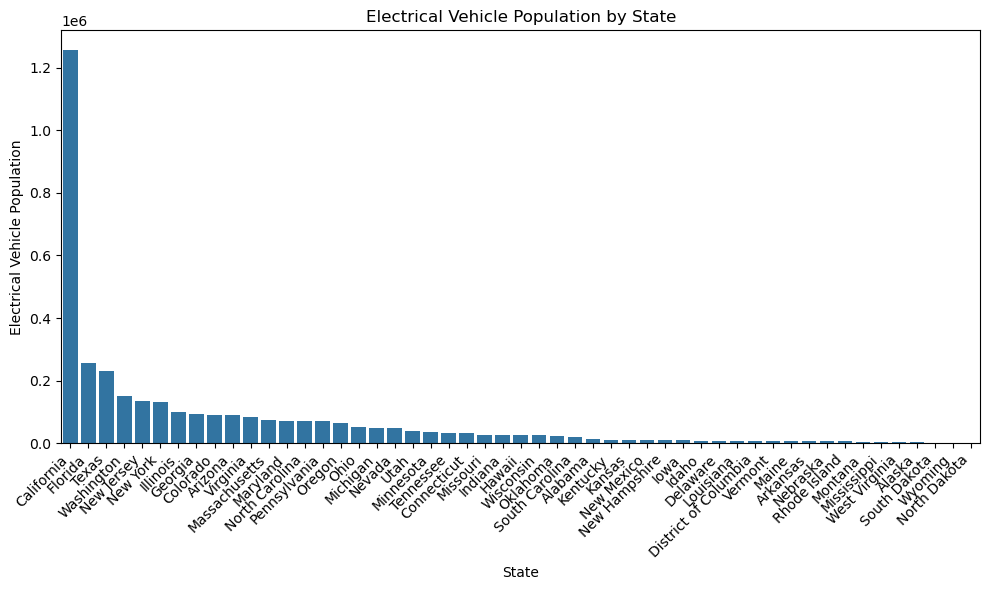

In [167]:
# Electrical Vehicle Population by State

plt.figure(figsize=(10,6))

sns.barplot(data=ev_state, x='state', y='registration_count')

plt.title('Electrical Vehicle Population by State')
plt.xlabel('State')
plt.ylabel('Electrical Vehicle Population')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

In [170]:
with open('data/ev_state.pickle', 'wb') as f:
    pickle.dump(ev_state, f)

# with open('data/ev_state.pickle', 'rb') as f:
#     ev_state = pickle.load(f)

---
## Electric Vehicle Population Status

Source: https://data.wa.gov/Transportation/Electric-Vehicle-Population-Data/f6w7-q2d2/about_data

Types of Electric Vehicle (EV) in the dataset:
1) Battery Electric Vehicle (BEV)
- "A Battery Electric Vehicle (BEV) is an all-electric vehicle using one or more batteries to store the electrical energy that powers the motor and is charged by plugging the vehicle in to an electric power source."
which is a general Electric (EV)

2) Plug-in Hybrid Electric Vehicle (PHEV)
- "A Plug-in Hybrid Electric Vehicle (PHEV) is a vehicle that uses one or more batteries to power an electric motor; uses another fuel, such as gasoline or diesel, to power an internal combustion engine or other propulsion source; and is charged by plugging the vehicle in to an electric power source."

Data Load

In [249]:
# Electric Vehicle Population Data

ev = pd.read_csv('./data/Electric_Vehicle_Population_Data_20241003.csv'
                 , dtype={'Postal Code':'object'
                          , 'Legislative District':'object'
                          , 'DOL Vehicle ID':'object'
                          , '2020 Census Tract':'object'})
# lower case
ev.columns = ['_'.join(col.strip().lower().split()) for col in ev.columns]
# change column names
ev.rename(columns={'vin_(1-10)':'vin'
                    , 'electric_vehicle_type':'ev_type'
                    , 'clean_alternative_fuel_vehicle_(cafv)_eligibility':'cafv_eligibility'}
           , inplace=True)

print_cols(ev, 2)

(205439, 17)


,vin,county,city,state,postal_code,model_year,make,model,ev_type,cafv_eligibility,electric_range,base_msrp,legislative_district,dol_vehicle_id,vehicle_location,electric_utility,2020_census_tract
0,JTMAB3FV3P,Kitsap,Seabeck,WA,98380,2023,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,42.0000,0.0000,35,240684006,POINT (-122.8728334 47.5798304),PUGET SOUND ENERGY INC,53035091301
1,1N4AZ1CP6J,Kitsap,Bremerton,WA,98312,2018,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,151.0000,0.0000,35,474183811,POINT (-122.6961203 47.5759584),PUGET SOUND ENERGY INC,53035080700


In [7]:
ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205439 entries, 0 to 205438
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   vin                   205439 non-null  object 
 1   county                205436 non-null  object 
 2   city                  205436 non-null  object 
 3   state                 205439 non-null  object 
 4   postal_code           205436 non-null  object 
 5   model_year            205439 non-null  int64  
 6   make                  205439 non-null  object 
 7   model                 205438 non-null  object 
 8   ev_type               205439 non-null  object 
 9   cafv_eligibility      205439 non-null  object 
 10  electric_range        205431 non-null  float64
 11  base_msrp             205431 non-null  float64
 12  legislative_district  204997 non-null  object 
 13  dol_vehicle_id        205439 non-null  object 
 14  vehicle_location      205431 non-null  object 
 15  

- size: 205,439 x 17

In [8]:
ev.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
vin,205439,12140,7SAYGDEE6P,1221,NaN,NaN,NaN,NaN,NaN,NaN,NaN
county,205436,205,King,105237,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,205436,770,Seattle,33328,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,205439,45,WA,204997,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postal_code,205436,930,98052,5203,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_year,205439.0,NaN,NaN,NaN,2020.960363,2.989059,1997.0,2019.0,2022.0,2023.0,2025.0
make,205439,42,TESLA,90318,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,205438,152,MODEL Y,43437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ev_type,205439,2,Battery Electric Vehicle (BEV),161539,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cafv_eligibility,205439,3,Eligibility unknown as battery range has not b...,114172,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- mostly categorical, nominal variables
- each row represents each dol_vehicle_id
- electric_range has values of 0, which is technically null
    - "Electric Range is no longer maintained for Battery Electric Vehicles (BEV) because new BEVs have an electric range of 30 miles or more. Zero (0) will be entered where the electric range has not been researched."
- model year 2025??

EDA

In [445]:
# vin
ev['vin'].value_counts()

vin
7SAYGDEE6P    1221
7SAYGDEE7P    1217
7SAYGDEEXP    1181
7SAYGDEE5P    1176
7SAYGDEE8P    1174
              ... 
YV4BC0PM5G       1
YV4ER3GL1R       1
WP0AB2Y12S       1
SALWV2RY9L       1
WA1LAAGE5M       1
Name: count, Length: 12140, dtype: int64

In [14]:
# dol_vehicle_id
ev['dol_vehicle_id'].value_counts()

dol_vehicle_id
240684006    1
249393770    1
150024689    1
261919150    1
251776654    1
            ..
251346868    1
266996754    1
212936545    1
207564941    1
228335040    1
Name: count, Length: 205439, dtype: int64

In [446]:
# vin and vehicle id pairs
ev[['vin','dol_vehicle_id']].value_counts()

vin         dol_vehicle_id
1C4JJXN60P  227539357         1
7SAYGDEE5P  270935024         1
            264911223         1
            265823974         1
            266835145         1
                             ..
5YJ3E1EA8P  254972210         1
            255011914         1
            255028728         1
            255122115         1
ZFAFFAC49R  270956304         1
Name: count, Length: 205439, dtype: int64

In [450]:
# check vin with multiple vehicle ids
cond = ev['vin'].str.contains('7SAYGDEE')
ev[cond].sort_values('vin')

,vin,county,city,state,postal_code,model_year,make,model,ev_type,cafv_eligibility,electric_range,base_msrp,legislative_district,dol_vehicle_id,vehicle_location,electric_utility,2020_census_tract
185035,7SAYGDEE0N,Snohomish,Bothell,WA,98021,2022,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,1,212134100,POINT (-122.2107298 47.7977268),PUGET SOUND ENERGY INC,53061051938
56720,7SAYGDEE0N,King,Sammamish,WA,98075,2022,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,41,219109110,POINT (-122.0181135 47.5880568),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033032213
200126,7SAYGDEE0N,Pierce,Gig Harbor,WA,98332,2022,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,26,193710912,POINT (-122.5966931 47.3616785),BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...,53053072508
140167,7SAYGDEE0N,King,Seattle,WA,98109,2022,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,36,203250785,POINT (-122.3441532 47.6305366),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),53033006702
127606,7SAYGDEE0N,Snohomish,Everett,WA,98204,2022,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,21,193753003,POINT (-122.2507211 47.8976713),PUGET SOUND ENERGY INC,53061041813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96597,7SAYGDEEXR,Snohomish,Everett,WA,98208,2024,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,44,267607455,POINT (-122.2032349 47.8956271),PUGET SOUND ENERGY INC,53061041606
152463,7SAYGDEEXR,Cowlitz,Castle Rock,WA,98611,2024,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,20,270054522,POINT (-122.893877 46.2844051),BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...,53015002003
147022,7SAYGDEEXR,King,Seattle,WA,98108,2024,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,37,264441943,POINT (-122.3173531 47.5484673),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),53033010101
70329,7SAYGDEEXR,King,Sammamish,WA,98075,2024,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,41,265096870,POINT (-122.0181135 47.5880568),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033032213


In [17]:
# county
ev['county'].value_counts().nlargest(10)

county
King         105237
Snohomish     24721
Pierce        16197
Clark         12231
Thurston       7526
Kitsap         6848
Spokane        5460
Whatcom        4978
Benton         2546
Skagit         2266
Name: count, dtype: int64

In [18]:
# city
ev['city'].value_counts().nlargest(10)

city
Seattle      33328
Bellevue     10235
Redmond       7341
Vancouver     7286
Bothell       6769
Kirkland      5998
Renton        5986
Sammamish     5908
Olympia       4966
Tacoma        4321
Name: count, dtype: int64

In [21]:
# model_year
ev['model_year'].value_counts().nlargest(10)

model_year
2023    60161
2024    30030
2022    28465
2021    19837
2018    14386
2020    12241
2019    10872
2017     8662
2016     5474
2015     4741
Name: count, dtype: int64

In [22]:
# make
ev['make'].value_counts().nlargest(10)

make
TESLA         90318
CHEVROLET     15114
NISSAN        14525
FORD          10840
KIA            9104
BMW            8481
TOYOTA         7945
HYUNDAI        5782
RIVIAN         5679
VOLKSWAGEN     5638
Name: count, dtype: int64

In [23]:
# model
ev['model'].value_counts().nlargest(10)

model
MODEL Y           43437
MODEL 3           32113
LEAF              13488
MODEL S            7881
BOLT EV            6727
MODEL X            6249
VOLT               4829
ID.4               4564
MUSTANG MACH-E     4154
WRANGLER           4047
Name: count, dtype: int64

In [452]:
# check if each vin has different models
grouped = ev.groupby('vin')['model'].nunique()
grouped[grouped > 1]

Series([], Name: model, dtype: int64)

In [315]:
# ev_type
ev['ev_type'].value_counts()

ev_type
Battery Electric Vehicle (BEV)            161539
Plug-in Hybrid Electric Vehicle (PHEV)     43900
Name: count, dtype: int64

There are only two types of vehicle in this dataset
1) Battery Electric Vehicle (BEV)
- "A Battery Electric Vehicle (BEV) is an all-electric vehicle using one or more batteries to store the electrical energy that powers the motor and is charged by plugging the vehicle in to an electric power source."
- which is a general Electric (EV)
2) Plug-in Hybrid Electric Vehicle (PHEV)
- "A Plug-in Hybrid Electric Vehicle (PHEV) is a vehicle that uses one or more batteries to power an electric motor; uses another fuel, such as gasoline or diesel, to power an internal combustion engine or other propulsion source; and is charged by plugging the vehicle in to an electric power source."

In [24]:
# cafv_eligibility
ev['cafv_eligibility'].value_counts()

cafv_eligibility
Eligibility unknown as battery range has not been researched    114172
Clean Alternative Fuel Vehicle Eligible                          70016
Not eligible due to low battery range                            21251
Name: count, dtype: int64

In [25]:
# electric_range
ev['electric_range'].value_counts()

electric_range
0.0      114172
215.0      6426
32.0       4895
25.0       4429
21.0       4220
          ...  
46.0          4
11.0          4
95.0          3
57.0          2
43.0          1
Name: count, Length: 105, dtype: int64

<Axes: >

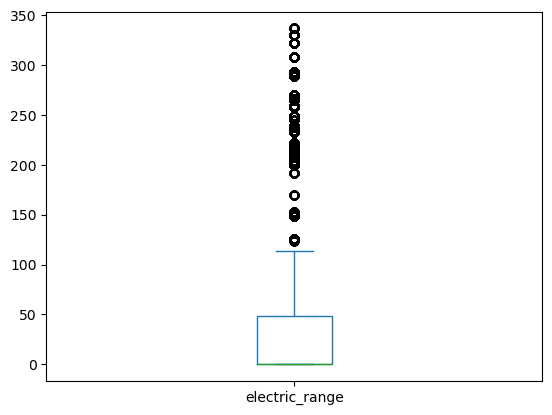

In [26]:
ev['electric_range'].plot(kind='box')

- many rows with 0 electric_range

In [11]:
# maker/brand that has higher electric range
cond = ev['electric_range'] != 0.0
ev[cond].groupby('make')['electric_range'].mean().sort_values(ascending=False)

make
TESLA                   241.101287
JAGUAR                  234.000000
POLESTAR                233.000000
CHEVROLET               141.599897
VOLKSWAGEN              107.363128
NISSAN                  104.908616
WHEEGO ELECTRIC CARS    100.000000
TH!NK                   100.000000
FIAT                     85.623077
KIA                      84.168486
HYUNDAI                  84.110837
AUDI                     78.316574
PORSCHE                  71.775862
SMART                    61.878543
AZURE DYNAMICS           56.000000
MINI                     48.738095
HONDA                    46.572261
BMW                      46.346467
LEXUS                    36.892421
CADILLAC                 36.681818
MERCEDES-BENZ            34.642292
ALFA ROMEO               33.000000
FISKER                   33.000000
CHRYSLER                 32.176821
DODGE                    32.000000
TOYOTA                   31.078312
MITSUBISHI               30.987230
LAND ROVER               28.971014
MAZDA          

In [28]:
# base_msrp
ev['base_msrp'].value_counts()

base_msrp
0.0         202114
69900.0       1359
31950.0        365
52900.0        220
32250.0        138
59900.0        128
54950.0        124
39995.0        116
36900.0        103
44100.0         99
64950.0         86
45600.0         81
52650.0         72
33950.0         71
34995.0         64
55700.0         54
36800.0         52
53400.0         39
81100.0         23
110950.0        21
98950.0         21
90700.0         16
102000.0        13
75095.0         11
184400.0        10
43700.0          9
89100.0          8
109000.0         6
91250.0          4
32995.0          3
845000.0         1
Name: count, dtype: int64

<Axes: >

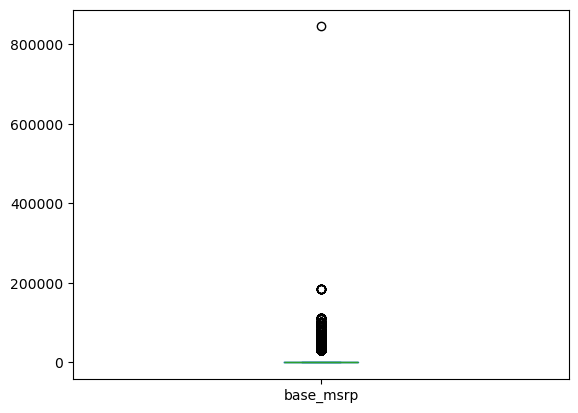

In [29]:
ev['base_msrp'].plot(kind='box')

- many rows with 0 base_msrp

In [12]:
# maker/brand that has higher electric range
cond = ev['base_msrp'] != 0.0
ev[cond].groupby('make')['base_msrp'].mean().sort_values(ascending=False)

make
PORSCHE                 133950.000000
FISKER                  102000.000000
CADILLAC                 75095.000000
TESLA                    70177.980456
VOLVO                    56286.601307
BMW                      52720.948617
CHRYSLER                 39995.000000
MINI                     36866.451613
SUBARU                   34995.000000
WHEEGO ELECTRIC CARS     32995.000000
KIA                      32269.512195
MERCEDES-BENZ                     NaN
Name: base_msrp, dtype: float64

In [38]:
# the number of electrical vehicles by each district
ev_by_district = ev['legislative_district'].value_counts().rename('ev_count')
ev_by_district

legislative_district
41    12994
45    12003
48    11184
1      8946
5      8787
11     8773
36     8297
46     7790
43     7236
37     5994
34     5933
44     5565
18     5508
21     5188
22     5122
32     5014
23     4409
40     4303
26     4095
47     3772
33     3739
31     3684
10     3566
17     3477
39     3045
35     2952
42     2930
49     2913
27     2865
24     2749
28     2698
30     2504
2      2424
25     2219
38     2161
8      2158
6      2004
12     1934
20     1929
4      1810
13     1503
29     1443
14     1356
19     1248
9      1171
16     1080
3      1012
7       973
15      537
Name: ev_count, dtype: int64

- legislative district values are numbers only

In [37]:
# ev by county
ev_by_county = ev['county'].value_counts().rename('ev_count')
ev_by_county

county
King           105237
Snohomish       24721
Pierce          16197
Clark           12231
Thurston         7526
                ...  
Maui                1
Plaquemines         1
Burlington          1
Mobile              1
Christian           1
Name: ev_count, Length: 205, dtype: int64

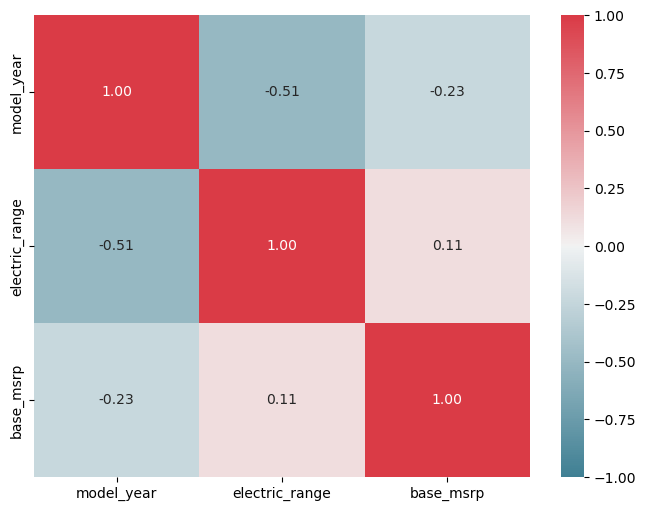

In [30]:
get_heatmap(ev)

Missing Values

vin                       0
county                    3
city                      3
state                     0
postal_code               3
model_year                0
make                      0
model                     1
ev_type                   0
cafv_eligibility          0
electric_range            8
base_msrp                 8
legislative_district    442
dol_vehicle_id            0
vehicle_location          8
electric_utility          3
2020_census_tract         3
dtype: int64


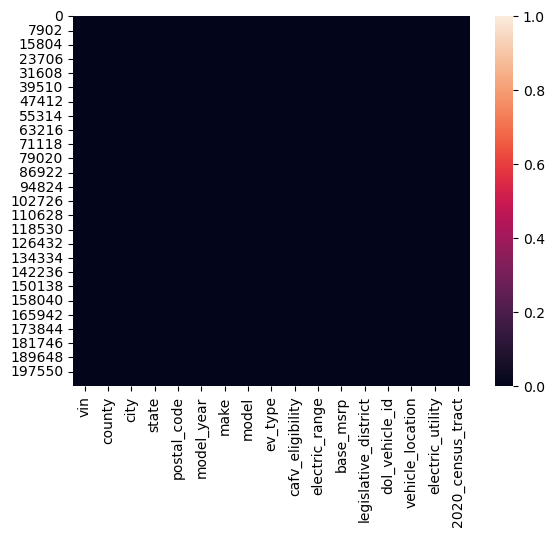

In [10]:
# check null heatmap
temp = ev.isna()
print(temp.sum())
sns.heatmap(temp);

- cannot really see null distribution through the heatmap

In [367]:
# null for county, city, postal code, electric_utility, and 2020_census_tract

cond = ev['county'].isna() | ev['city'].isna() | ev['postal_code'].isna() | ev['electric_utility'].isna() | ev['2020_census_tract'].isna()
temp = ev[cond]
print(temp.shape)
temp

(3, 17)


,vin,county,city,state,postal_code,model_year,make,model,ev_type,cafv_eligibility,electric_range,base_msrp,legislative_district,dol_vehicle_id,vehicle_location,electric_utility,2020_census_tract
138102,WBAJA9C50K,NaN,NaN,AE,NaN,2019,BMW,530E,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,16.0,53400.0,NaN,244582593,NaN,NaN,NaN
182254,5YJXCAE24H,NaN,NaN,BC,NaN,2017,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,200.0,0.0,NaN,159850029,NaN,NaN,NaN
203466,1G1RB6S53J,NaN,NaN,BC,NaN,2018,CHEVROLET,VOLT,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,53.0,0.0,NaN,477613216,NaN,NaN,NaN


- 3 data where county, city, postal code, electric_utility, and 2020_census_tract are null
- all from differnet state
- --> remove

In [351]:
# null for model
cond = ev['model'].isna()
ev[cond]

,vin,county,city,state,postal_code,model_year,make,model,ev_type,cafv_eligibility,electric_range,base_msrp,legislative_district,dol_vehicle_id,vehicle_location,electric_utility,2020_census_tract
43570,1GT10DDB5S,Clark,Vancouver,WA,98663,2025,GMC,NaN,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,49,269752913,POINT (-122.657848 45.654422),BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...,53011041011


In [353]:
ev[ev['make'] == 'GMC']['model'].value_counts()

model
HUMMER EV PICKUP    34
Name: count, dtype: int64

- In this dataset, all the electric vehicles made by GMC is 'HUMMER EV PICKUP'
- --> Therefore, will fill the null value as 'HUMMER EV PICKUP'

In [359]:
# null for electric_range and base_msrp       
cond = ev['electric_range'].isna() | ev['base_msrp'].isna()
temp = ev[cond]
print(temp.shape)
temp

(8, 17)


,vin,county,city,state,postal_code,model_year,make,model,ev_type,cafv_eligibility,electric_range,base_msrp,legislative_district,dol_vehicle_id,vehicle_location,electric_utility,2020_census_tract
31588,W1K6G8CB9R,King,Des Moines,WA,98198,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,NaN,NaN,33,268383069,POINT (-122.3145447 47.3984346),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033029001
82616,W1K6G8CB7R,Clark,Vancouver,WA,98664,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,NaN,NaN,49,267549005,POINT (-122.575383 45.620105),BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...,53011043100
84294,W1K6G8CB9R,Clark,Vancouver,WA,98664,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,NaN,NaN,49,271731323,POINT (-122.575383 45.620105),BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...,53011043100
91234,W1K6G8CB2R,Clark,Vancouver,WA,98664,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,NaN,NaN,49,270010520,POINT (-122.575383 45.620105),BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...,53011043100
125730,W1K6G8CB3R,King,Auburn,WA,98092,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,NaN,NaN,31,269271873,POINT (-122.1550193 47.2884536),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033031204
127349,W1K6G8CB3R,Snohomish,Woodway,WA,98020,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,NaN,NaN,32,268002164,POINT (-122.3757836 47.800042),PUGET SOUND ENERGY INC,53061050600
148606,W1K6G8CB5R,Pierce,Tacoma,WA,98405,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,NaN,NaN,27,273293821,POINT (-122.46564 47.2457),BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...,53053061300
159687,W1K6G8CB5R,King,Seattle,WA,98118,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,NaN,NaN,37,269456498,POINT (-122.2753318 47.5411053),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),53033011802


In [366]:
cond = (ev['model_year'] == 2024) & (ev['make'] == 'MERCEDES-BENZ') & (ev['model'] == 'S-CLASS')
ev[cond]

,vin,county,city,state,postal_code,model_year,make,model,ev_type,cafv_eligibility,electric_range,base_msrp,legislative_district,dol_vehicle_id,vehicle_location,electric_utility,2020_census_tract
13273,W1K6G6KB0R,Snohomish,Everett,WA,98208,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,46.0,0.0,21,261762462,POINT (-122.2032349 47.8956271),PUGET SOUND ENERGY INC,53061041808
31588,W1K6G8CB9R,King,Des Moines,WA,98198,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,NaN,NaN,33,268383069,POINT (-122.3145447 47.3984346),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033029001
57148,W1K6G6KB8R,King,Kirkland,WA,98033,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,46.0,0.0,45,269293412,POINT (-122.1925969 47.676241),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033022502
74028,W1K6G6KBXR,King,Seattle,WA,98117,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,46.0,0.0,36,263004689,POINT (-122.377938 47.690166),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),53033003000
82616,W1K6G8CB7R,Clark,Vancouver,WA,98664,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,NaN,NaN,49,267549005,POINT (-122.575383 45.620105),BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...,53011043100
84294,W1K6G8CB9R,Clark,Vancouver,WA,98664,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,NaN,NaN,49,271731323,POINT (-122.575383 45.620105),BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...,53011043100
91234,W1K6G8CB2R,Clark,Vancouver,WA,98664,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,NaN,NaN,49,270010520,POINT (-122.575383 45.620105),BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...,53011043100
125730,W1K6G8CB3R,King,Auburn,WA,98092,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,NaN,NaN,31,269271873,POINT (-122.1550193 47.2884536),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),53033031204
127349,W1K6G8CB3R,Snohomish,Woodway,WA,98020,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,NaN,NaN,32,268002164,POINT (-122.3757836 47.800042),PUGET SOUND ENERGY INC,53061050600
148606,W1K6G8CB5R,Pierce,Tacoma,WA,98405,2024,MERCEDES-BENZ,S-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,NaN,NaN,27,273293821,POINT (-122.46564 47.2457),BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...,53053061300


- all the data, where electric_range and base_msrp are null, in common has 2024 for model_year, MERCEDES-BENZ for make, S-CLASS for model
- all the other 2024 benz s-class model has 46 for electric_range and 0 base_msrp, therefore, will replace the null with 46 and 0 respectively

In [368]:
# null for vehicle_location

cond = ev['vehicle_location'].isna()
temp = ev[cond]
print(temp.shape)
temp

(8, 17)


,vin,county,city,state,postal_code,model_year,make,model,ev_type,cafv_eligibility,electric_range,base_msrp,legislative_district,dol_vehicle_id,vehicle_location,electric_utility,2020_census_tract
138046,KNDJX3AE8H,Pacific,Long Beach,WA,98634,2017,KIA,SOUL EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,93.0,32250.0,19,106442773,NaN,BONNEVILLE POWER ADMINISTRATION||PUD NO 2 OF P...,53049950501
138102,WBAJA9C50K,NaN,NaN,AE,NaN,2019,BMW,530E,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,16.0,53400.0,NaN,244582593,NaN,NaN,NaN
148503,1C4JJXP69P,Pacific,Long Beach,WA,98634,2023,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21.0,0.0,19,254934886,NaN,BONNEVILLE POWER ADMINISTRATION||PUD NO 2 OF P...,53049950600
176278,1G1FW6S08N,Pacific,Long Beach,WA,98634,2022,CHEVROLET,BOLT EV,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,19,218102209,NaN,BONNEVILLE POWER ADMINISTRATION||PUD NO 2 OF P...,53049950600
178268,7SAYGDEE0N,Pacific,Long Beach,WA,98634,2022,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,19,211479649,NaN,BONNEVILLE POWER ADMINISTRATION||PUD NO 2 OF P...,53049950600
178396,KMHE54L2XH,Pacific,Long Beach,WA,98634,2017,HYUNDAI,SONATA,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,27.0,0.0,19,245533578,NaN,BONNEVILLE POWER ADMINISTRATION||PUD NO 2 OF P...,53049950501
182254,5YJXCAE24H,NaN,NaN,BC,NaN,2017,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,200.0,0.0,NaN,159850029,NaN,NaN,NaN
203466,1G1RB6S53J,NaN,NaN,BC,NaN,2018,CHEVROLET,VOLT,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,53.0,0.0,NaN,477613216,NaN,NaN,NaN


- 8 data where vehicle_location is null
- 3 of them are from different states
- vehicle location is not neccessary for my analysis
- but if i will be using geo/map visualization methods and i feel like needing it,
    - --> since they all are from legislative district 19, I can extract/get the central locaiton of them and using the valuue, I can fill the null

In [344]:
# null for legislative_district

cond = ev['legislative_district'].isna()
ev[cond][['state','electric_utility']].head()

,state,electric_utility
26697,MO,NON WASHINGTON STATE ELECTRIC UTILITY
33457,CA,NON WASHINGTON STATE ELECTRIC UTILITY
38814,VA,NON WASHINGTON STATE ELECTRIC UTILITY
40765,NC,NON WASHINGTON STATE ELECTRIC UTILITY
42678,MD,NON WASHINGTON STATE ELECTRIC UTILITY


- different states
    - "NON WASHINGTON STATE ELECTRIC UTILITY"
- --> remove

Handling missing values:
- Remove rows where multiple columns are simultaneously null.
- Handle missing values for the model of GMC vehicles.
- Handle missing values for the electric_range and base_msrp of Mercedes-Benz S-CLASS.
- Remove rows where legislative_district is null.

Handling outliers
- For numerical variables: Identify and handle outliers using the IQR method.
- For categorical variables: Identify categories with very low frequencies and replace them with 'Other'.

In [250]:
## Handling missing values

# county, city, postal code, electric_utility, 2020_census_tract -> remove null
ev = ev.dropna(subset=['county', 'city', 'postal_code', 'electric_utility', '2020_census_tract'], how='all')

# model -> impute
ev.loc[ev['make'] == 'GMC', 'model'] = ev.loc[ev['make'] == 'GMC', 'model'].fillna('HUMMER EV PICKUP')

# electric_range, base_msrp -> impute
cond = (ev['model_year'] == 2024) & (ev['make'] == 'MERCEDES-BENZ') & (ev['model'] == 'S-CLASS')
ev.loc[cond, 'electric_range'] = ev.loc[cond, 'electric_range'].fillna(46)
ev.loc[cond, 'base_msrp'] = ev.loc[cond, 'base_msrp'].fillna(0)

# vehicle_location
# -> later, if necessary

# legislative_district -> drop null
ev = ev.dropna(subset=['legislative_district'])

# Categorical columns
# categorical_columns = ['county', 'city', 'make', 'model', 'ev_type', 'cafv_eligibility', 'electric_utility']
categorical_columns = ['ev_type', 'cafv_eligibility', 'electric_utility']

for col in categorical_columns:
    value_counts = ev[col].value_counts()
    rare_categories = value_counts[value_counts < len(ev) * 0.01].index  # 1% 미만의 빈도를 가진 범주
    print(f"\nRare categories in {col}:")
    print(rare_categories)
    
    # replace with 'Other'
    ev[col] = ev[col].replace(rare_categories, 'Other')

# after preprocessing
print("\nData shape after preprocessing:", ev.shape)
print("\nNull values after preprocessing:")
print(ev.isnull().sum())


Rare categories in ev_type:
Index([], dtype='object', name='ev_type')

Rare categories in cafv_eligibility:
Index([], dtype='object', name='cafv_eligibility')

Rare categories in electric_utility:
Index(['BONNEVILLE POWER ADMINISTRATION||PUD 1 OF SNOHOMISH COUNTY',
       'PACIFICORP',
       'BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF BENTON COUNTY',
       'MODERN ELECTRIC WATER COMPANY', 'PUD NO 1 OF CHELAN COUNTY',
       'BONNEVILLE POWER ADMINISTRATION||PUGET SOUND ENERGY INC||PUD NO 1 OF JEFFERSON COUNTY',
       'BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF COWLITZ COUNTY',
       'BONNEVILLE POWER ADMINISTRATION||CITY OF RICHLAND - (WA)',
       'BONNEVILLE POWER ADMINISTRATION||ORCAS POWER & LIGHT COOP',
       'BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF CLALLAM COUNTY',
       'BONNEVILLE POWER ADMINISTRATION||CITY OF TACOMA - (WA)||PUD NO 3 OF MASON COUNTY',
       'BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF GRAYS HARBOR COUNTY',
       'PUD NO 2 OF GRANT COUNTY',
  

Outliers

In [12]:
# Check outliers

# Numeric columns
numeric_columns = ['model_year', 'electric_range', 'base_msrp']

# IQR based outlier check
for col in numeric_columns:
    Q1 = ev[col].quantile(0.25)
    Q3 = ev[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"\nOutliers in {col}:")
    print(ev[(ev[col] < lower_bound) | (ev[col] > upper_bound)][col].describe())
    
    # replace with lower bound and upper bound
    # ev[col] = ev[col].clip(lower_bound, upper_bound)


Outliers in model_year:
count    2317.000000
mean     2011.558481
std         1.117711
min      1997.000000
25%      2011.000000
50%      2012.000000
75%      2012.000000
max      2012.000000
Name: model_year, dtype: float64

Outliers in electric_range:
count    36860.000000
mean       230.216007
std         44.796092
min        124.000000
25%        210.000000
50%        220.000000
75%        259.000000
max        337.000000
Name: electric_range, dtype: float64

Outliers in base_msrp:
count      3317.000000
mean      57143.542358
std       22772.943759
min       31950.000000
25%       39995.000000
50%       59900.000000
75%       69900.000000
max      845000.000000
Name: base_msrp, dtype: float64


In [13]:
# Categorical columns
categorical_columns = ['county', 'city', 'make', 'model', 'ev_type', 'cafv_eligibility', 'electric_utility']

for col in categorical_columns:
    value_counts = ev[col].value_counts()
    rare_categories = value_counts[value_counts < len(ev) * 0.01].index  # below 1% frequency
    print(f"\nRare categories in {col}:")
    print(rare_categories)
    
    # replace with 'Other'
    # ev[col] = ev[col].replace(rare_categories, 'Other')


Rare categories in county:
Index(['Chelan', 'Yakima', 'Clallam', 'Jefferson', 'Cowlitz', 'San Juan',
       'Mason', 'Lewis', 'Kittitas', 'Grays Harbor',
       ...
       'Richland', 'Sarpy', 'Rockdale', 'Rockingham', 'Lane', 'Maui',
       'Plaquemines', 'Burlington', 'Mobile', 'Christian'],
      dtype='object', name='county', length=194)

Rare categories in city:
Index(['Bainbridge Island', 'Camas', 'Maple Valley', 'Federal Way',
       'Lake Stevens', 'Bremerton', 'Puyallup', 'Marysville', 'Port Orchard',
       'Seatac',
       ...
       'Reno', 'Lompoc', 'Dover', 'Martha Lake', 'North Las Vegas', 'Peoria',
       'Winterville', 'Sarasota', 'Aberdeen Proving Ground', 'Wishram'],
      dtype='object', name='city', length=746)

Rare categories in make:
Index(['MERCEDES-BENZ', 'SUBARU', 'PORSCHE', 'POLESTAR', 'HONDA', 'MITSUBISHI',
       'MINI', 'FIAT', 'LEXUS', 'CADILLAC', 'MAZDA', 'DODGE', 'LINCOLN',
       'LUCID', 'GENESIS', 'SMART', 'JAGUAR', 'FISKER', 'ALFA ROMEO',
       '

- There are outliers in several columns

In [268]:
# import pickle

with open('data/ev.pickle', 'wb') as f:
    pickle.dump(ev, f)

# with open('data/ev.pickle', 'rb') as f:
#     ev = pickle.load(f)

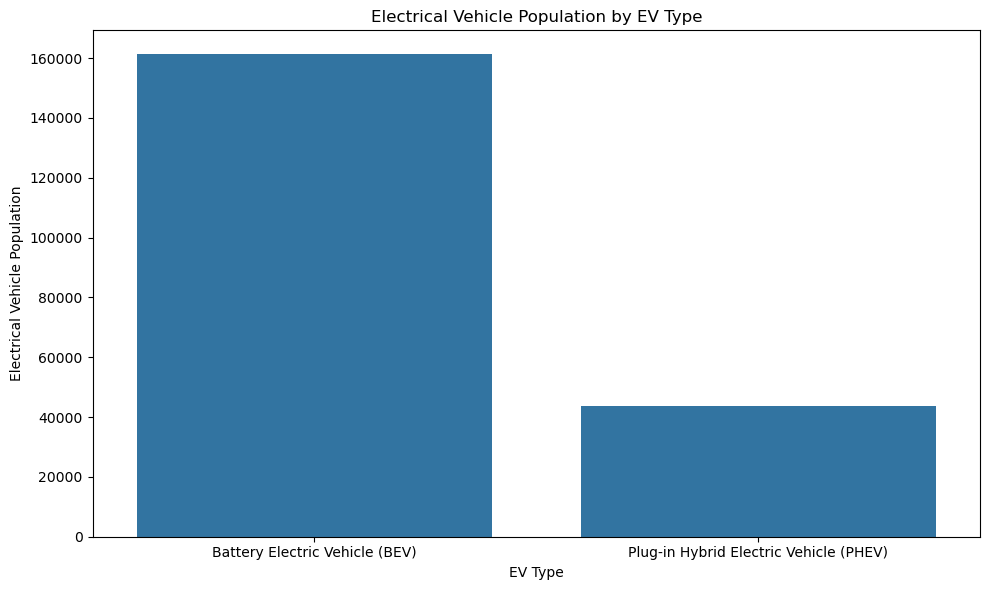

In [59]:
# Electrical Vehicle Population by EV Type

plt.figure(figsize=(10,6))

sns.countplot(data=ev, x='ev_type'
             , order=ev['ev_type'].value_counts().index)

plt.title('Electrical Vehicle Population by EV Type')
plt.xlabel('EV Type')
plt.ylabel('Electrical Vehicle Population')
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

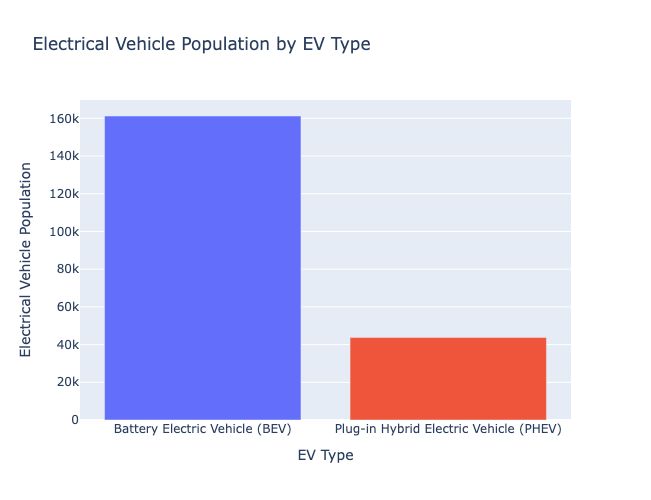

In [140]:
# Try Plotly

# EV 타입별 카운트 계산
ev_type_counts = ev['ev_type'].value_counts().reset_index()
ev_type_counts.columns = ['ev_type', 'count']

# Plotly를 사용한 바 차트 생성
fig = px.bar(ev_type_counts, x='ev_type', y='count',
             title='Electrical Vehicle Population by EV Type',
             labels={'count': 'Electrical Vehicle Population', 'ev_type': 'EV Type'},
             color='ev_type')

# 레이아웃 조정
fig.update_layout(
    xaxis_title='EV Type',
    yaxis_title='Electrical Vehicle Population',
    showlegend=False,
    width=800,
    height=500
)

# 차트 표시
fig.show()

In [172]:
# Get Plotly's default color sequence
print(px.colors.qualitative.Plotly)

['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']


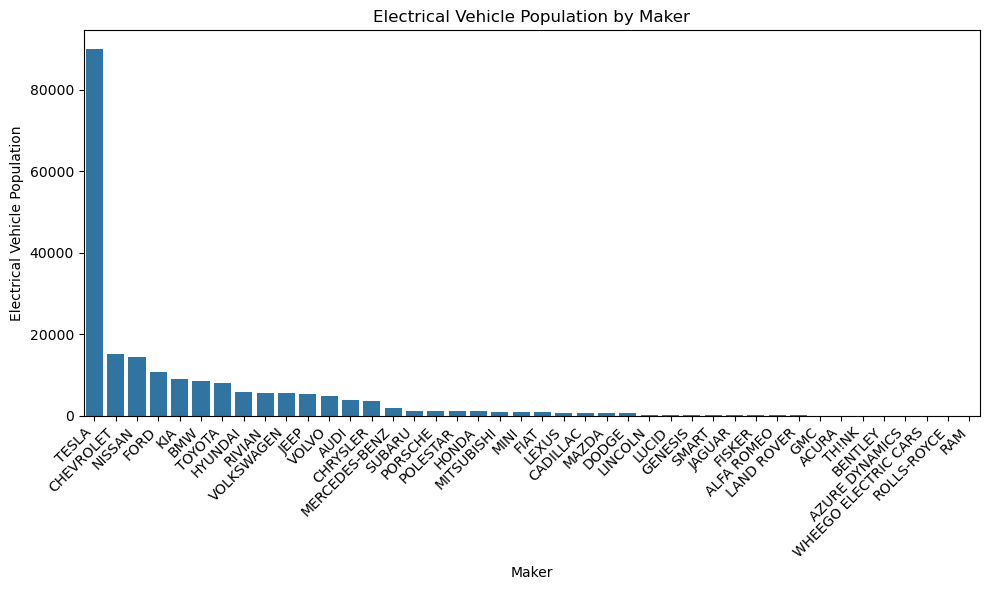

In [269]:
# Electrical Vehicle Population by Maker

plt.figure(figsize=(10,6))

sns.countplot(data=ev, x='make'
             , order=ev['make'].value_counts().index)

plt.title('Electrical Vehicle Population by Maker')
plt.xlabel('Maker')
plt.ylabel('Electrical Vehicle Population')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

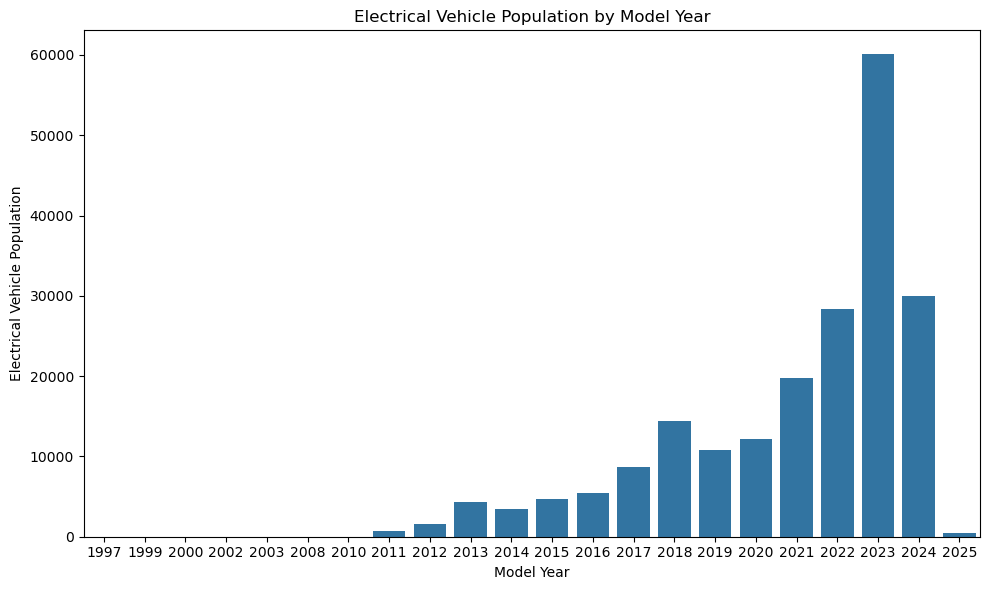

In [61]:
# Electrical Vehicle Population by Model Year

plt.figure(figsize=(10,6))

sns.countplot(data=ev, x='model_year')

plt.title('Electrical Vehicle Population by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Electrical Vehicle Population')
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

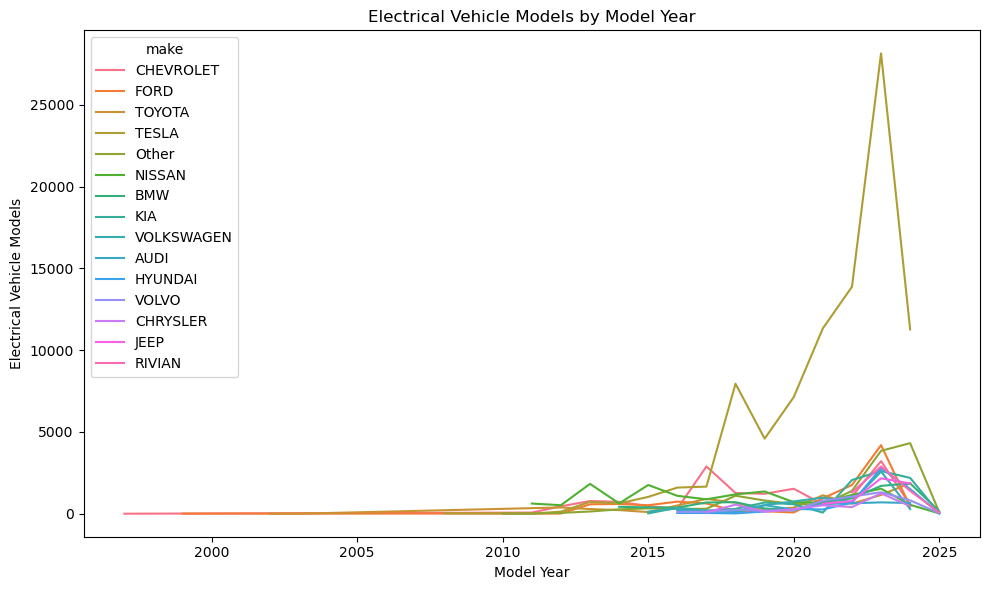

In [228]:
# Electrical Vehicle Models by Model Year

plt.figure(figsize=(10,6))

model_counts = ev.groupby(['model_year', 'make']).size().reset_index(name='count')
sns.lineplot(data=model_counts, x='model_year', y='count', hue='make')

plt.title('Electrical Vehicle Models by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Electrical Vehicle Models')
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

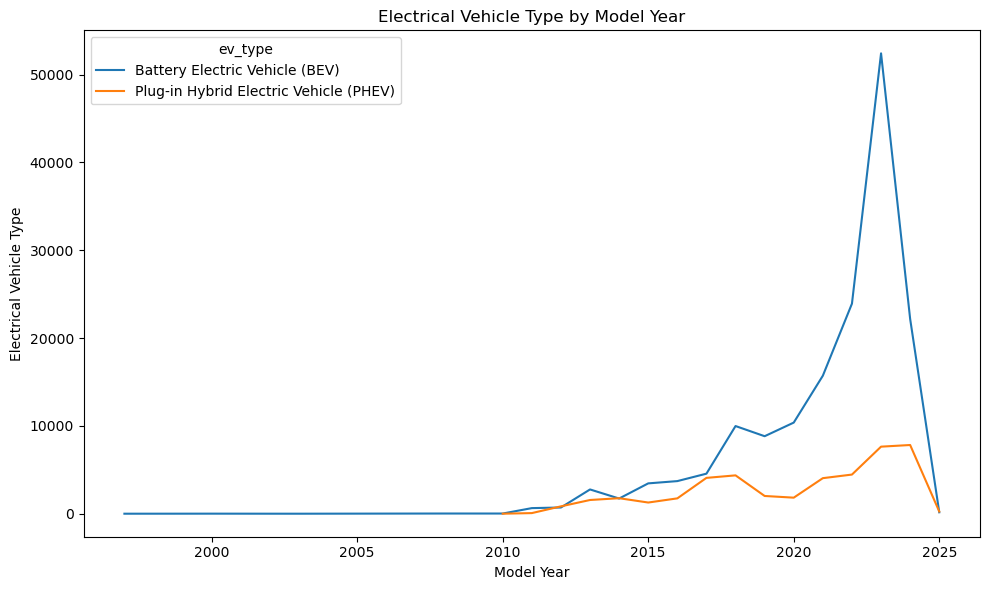

In [229]:
# Electrical Vehicle Type by Model Year

plt.figure(figsize=(10,6))

model_counts = ev.groupby(['model_year', 'ev_type']).size().reset_index(name='count')
sns.lineplot(data=model_counts, x='model_year', y='count', hue='ev_type')

plt.title('Electrical Vehicle Type by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Electrical Vehicle Type')
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

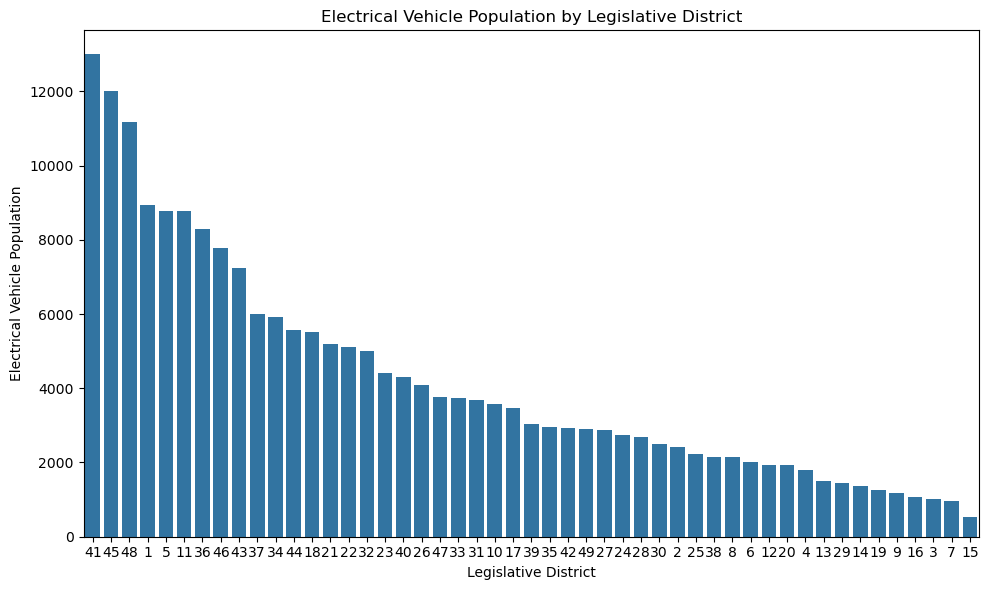

In [110]:
# Electrical Vehicle Population by Legislative District

order_ld = ev['legislative_district'].value_counts().index

plt.figure(figsize=(10,6))
sns.countplot(data=ev, x='legislative_district'
             , order=order_ld)
plt.title('Electrical Vehicle Population by Legislative District')
plt.xlabel('Legislative District')
plt.ylabel('Electrical Vehicle Population')
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

---
## 2022 General Election Results in Washington State

Source: https://www.kaggle.com/datasets/josephdemey/2022-washington-state-legislative-election-results

- United States state legislative elections (US Senator election) occurred in 2022 in the Washington state

In [251]:
# 2022 election results by legislative district
election_ld = pd.read_excel('data/2022gen results by legislative district.xlsx', sheet_name='FINAL by LD', header=[1], nrows=49)

# filter columns
include_cols = ['District Name','Registered Voters','Ballots Cast','% Turnout','Patty Murray','Tiffany Smiley']
election_ld = election_ld[include_cols]

# lower columns
election_ld.columns = ['_'.join(col.strip().lower().split()) for col in election_ld.columns]

# rename columns
election_ld.rename(columns={'district_name':'legislative_district'}, inplace=True)

election_ld.head(1)

,legislative_district,registered_voters,ballots_cast,%_turnout,patty_murray,tiffany_smiley
0,Legislative District 1,99789,69622,0.697692,48493,20631


In [34]:
elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   legislative_district  49 non-null     object 
 1   registered_voters     49 non-null     int64  
 2   ballots_cast          49 non-null     int64  
 3   %_turnout             49 non-null     float64
 4   patty_murray          49 non-null     int64  
 5   tiffany_smiley        49 non-null     int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 2.4+ KB


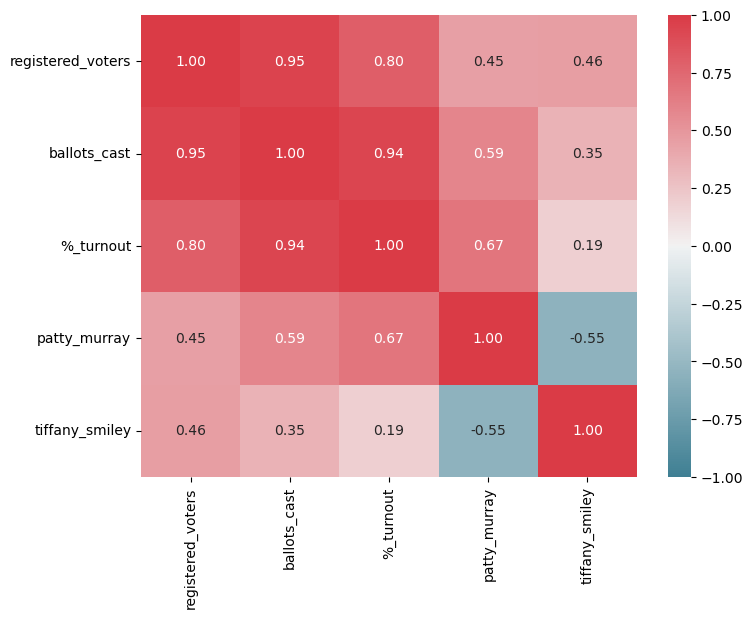

In [33]:
get_heatmap(elec)

In [252]:
# keep only number value in district column for merge with main table
election_ld['legislative_district'] = election_ld['legislative_district'].apply(lambda x: x.split()[-1])

# create a column of election winner party
def find_winner(df):
    if df['patty_murray'] > df['tiffany_smiley']:
        return 'Democratic'
    else:
        return 'Republican'

election_ld['party_won'] = election_ld.apply(find_winner, axis=1)
election_ld.head(1)

,legislative_district,registered_voters,ballots_cast,%_turnout,patty_murray,tiffany_smiley,party_won
0,1,99789,69622,0.697692,48493,20631,Democratic


In [253]:
# Merge
# groupby legislative_district and merge

# main ev data
# save the number of electrical vehicles by each district
ev_district = ev['legislative_district'].value_counts().rename('ev_count')

# election data
# add ev count as a new column to the election result table
ev_merged = pd.merge(left=ev_district, right=election_ld, how='inner', on='legislative_district') # inner join

print_cols(ev_merged, 2)

(49, 8)


,legislative_district,ev_count,registered_voters,ballots_cast,%_turnout,patty_murray,tiffany_smiley,party_won
0,41,12994,98278,65840,0.6699,45730,19526,Democratic
1,45,12003,96577,67381,0.6977,46385,20531,Democratic


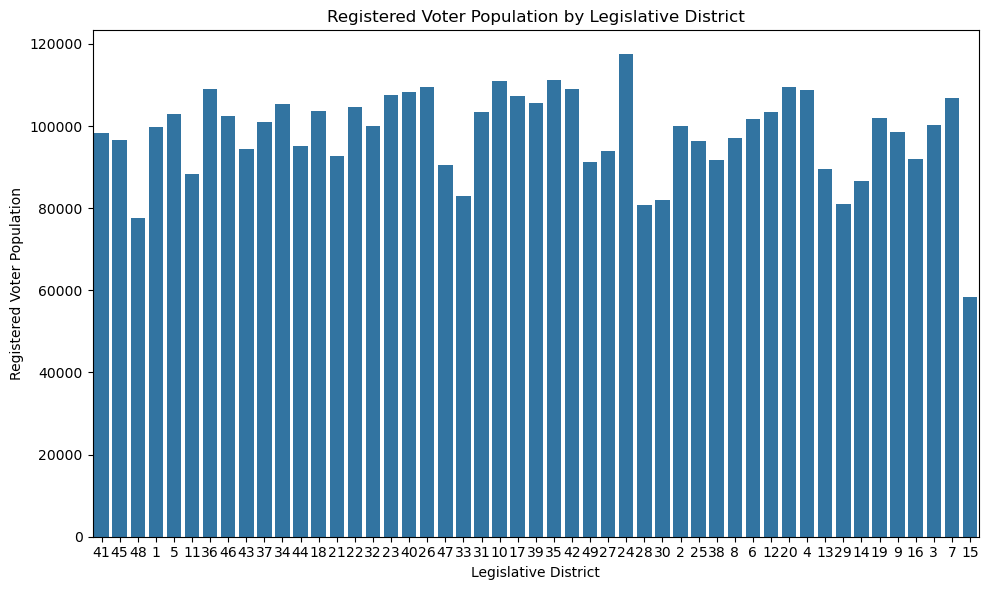

In [67]:
# Registered Voter Population by Legislative District

plt.figure(figsize=(10,6))

# temp = ev_elec.groupby('legislative_district')['registered_voters'].mean()
# sns.barplot(data=temp, order=order_ld)
sns.barplot(data=ev_merged, x='legislative_district', y='registered_voters', order=order_ld)

plt.title('Registered Voter Population by Legislative District')
plt.xlabel('Legislative District')
plt.ylabel('Registered Voter Population')
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

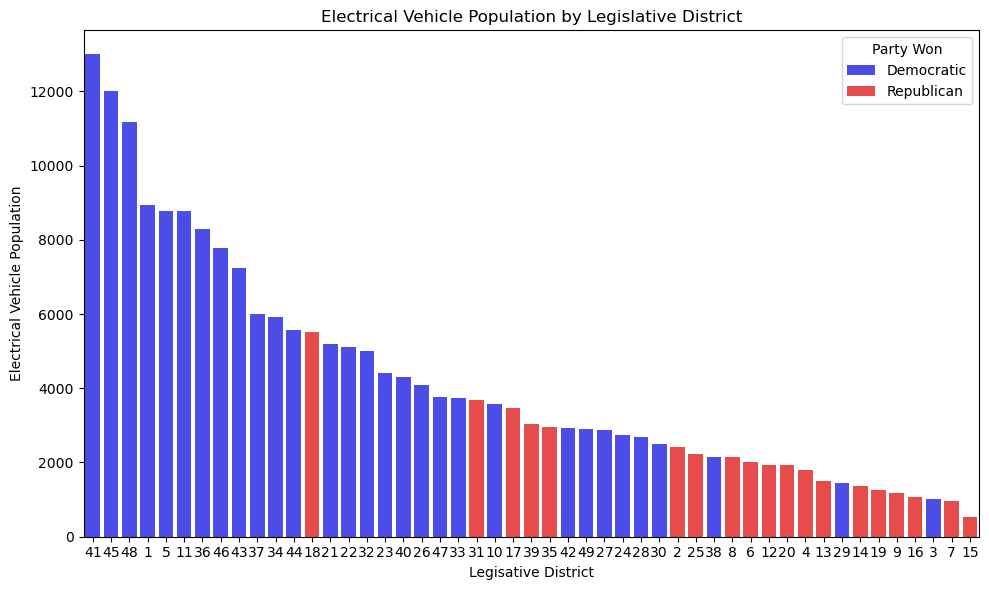

In [69]:
# plot for ev population per district
# political party color coded

us_political_party_colors = {
    'Democratic': {'hex':'#3333FF', 'rgb':(51, 51, 255)}, # light blue
    'Republican': {'hex':'#FF3333', 'rgb':(255, 51, 51)} # light red
}
democratic_color = us_political_party_colors['Democratic']['hex']
republican_color = us_political_party_colors['Republican']['hex']
party_colors = {'Democratic':democratic_color, 'Republican':republican_color}

plt.figure(figsize=(10,6))
# sns.countplot(data=ev_elec, x='legislative_district'
#               , order=order_ld, hue='party_won', palette=party_colors)
sns.barplot(data=ev_merged, x='legislative_district', y='ev_count'
              , order=order_ld, hue='party_won', palette=party_colors)
plt.title('Electrical Vehicle Population by Legislative District')
plt.xlabel('Legisative District')
plt.ylabel('Electrical Vehicle Population')
plt.legend(title='Party Won')
plt.tight_layout()
plt.show();

EV Count 분포 통계:
min: 537.00
max: 12994.00
mean: 4183.61
median: 3045.00
25%: 2004.00
75%: 5508.00
Skewness: 1.2624551870982634
Kurtosis: 1.0520433149809016


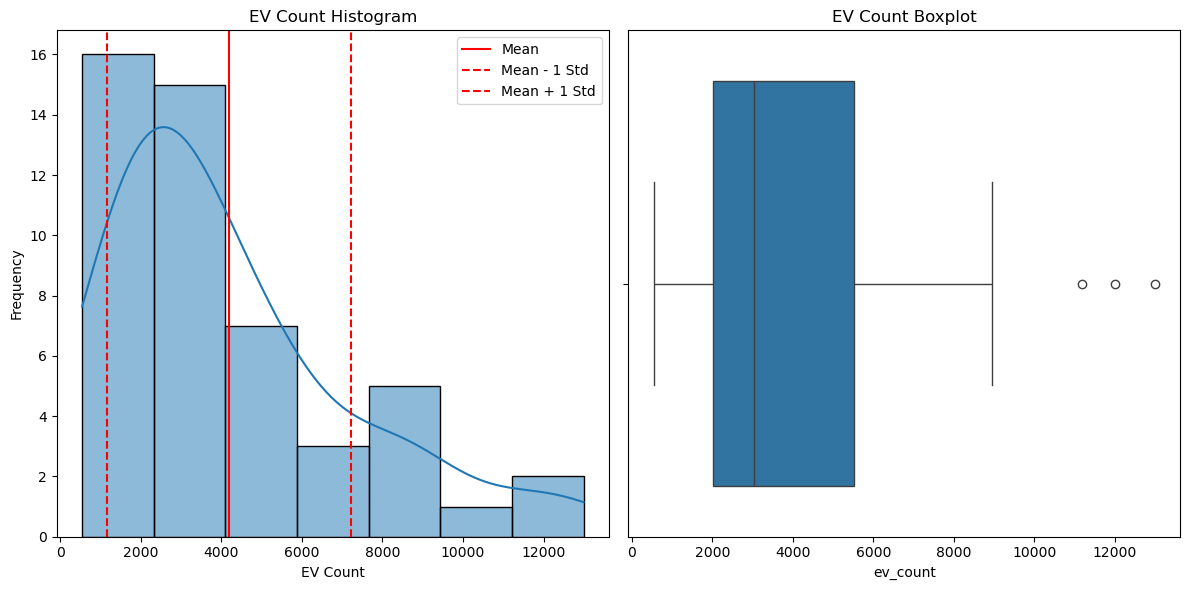

In [39]:
# Visualizing target column distribution
# Determine the best method for categorization and class labeling by checking the distribution

# EV count data from the dataset
ev_count = ev_merged['ev_count']

# Basic statistics for EV count
stats = {
    'min': ev_count.min(),
    'max': ev_count.max(),
    'mean': ev_count.mean(),
    'median': ev_count.median(),
    '25%': ev_count.quantile(0.25),
    '75%': ev_count.quantile(0.75)
}
print("EV Count 분포 통계:") # Distribution Statistics
for key, value in stats.items():
    print(f"{key}: {value:.2f}")

# Plot 1: Data distribution visualization (Histogram)
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.histplot(ev_count, kde=True)
plt.title('EV Count Histogram')
plt.xlabel('EV Count')
plt.ylabel('Frequency')

# Highlight boundaries based on normal distribution
mean, std = ev_count.mean(), ev_count.std()
plt.axvline(mean, color='r', linestyle='-', label='Mean')
plt.axvline(mean - std, color='r', linestyle='--', label='Mean - 1 Std')
plt.axvline(mean + std, color='r', linestyle='--', label='Mean + 1 Std')
plt.legend()

# Check skewness and kurtosis
print("Skewness:", ev_count.skew())
print("Kurtosis:", ev_count.kurtosis())

# Plot 2: Data distribution visualization (Boxplot)
plt.subplot(122)
sns.boxplot(x=ev_count)
plt.title('EV Count Boxplot')

plt.tight_layout()
plt.show()

## Alternative Fuel Stations in Washington State

- Electric charging station information such as location
- https://afdc.energy.gov/data_download

In [255]:
# read alternative fuel stations in washington dataset
# source: https://afdc.energy.gov/data_download

charger = pd.read_csv('data/alt_fuel_stations (Oct 7 2024).csv')
charger.columns = ['_'.join(col.strip().lower().split()) for col in charger.columns]

# drop all-null cols
charger = charger.dropna(axis=1, how='all')

print_cols(charger, 2)

(2705, 41)


,fuel_type_code,station_name,street_address,intersection_directions,city,state,zip,station_phone,status_code,expected_date,groups_with_access_code,access_days_time,cards_accepted,ev_level1_evse_num,ev_level2_evse_num,ev_dc_fast_count,ev_network,ev_network_web,geocode_status,latitude,longitude,date_last_confirmed,id,updated_at,owner_type_code,federal_agency_id,federal_agency_name,open_date,ev_connector_types,country,groups_with_access_code_(french),access_code,access_detail_code,federal_agency_code,facility_type,ev_pricing,ev_on-site_renewable_source,restricted_access,nps_unit_name,maximum_vehicle_class,ev_workplace_charging
0,ELEC,City of Lacey - City Hall Parking,420 College St,"At 3rd Ave SE, next to police station",Lacey,WA,98503,360-491-3214,E,NaN,Public,24 hours daily,NaN,NaN,4.0000,NaN,Non-Networked,NaN,200-9,47.0440,-122.8224,2023-01-10,33351,2023-02-14 15:54:11 UTC,LG,NaN,NaN,2018-01-15,J1772,US,Public,public,NaN,NaN,MUNI_GOV,Free; 3 hour maximum charging session,NaN,False,NaN,LD,False
1,ELEC,Seattle-Tacoma International Airport - General...,17801 Pacific Hwy S,"5th floor parking garage; rows D, G, and I",Seattle,WA,98188,206-787-5388,E,NaN,Public,24 hours daily; pay lot; Drivers must bring th...,NaN,NaN,68.0000,NaN,Non-Networked,NaN,200-8,47.4434,-122.2962,2023-12-13,33717,2024-01-31 22:07:01 UTC,P,NaN,NaN,2010-03-01,J1772,US,Public,public,NaN,NaN,AIRPORT,Free,NaN,False,NaN,LD,False


In [605]:
charger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705 entries, 0 to 2704
Data columns (total 75 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   fuel_type_code                           2705 non-null   object 
 1   station_name                             2705 non-null   object 
 2   street_address                           2702 non-null   object 
 3   intersection_directions                  801 non-null    object 
 4   city                                     2705 non-null   object 
 5   state                                    2705 non-null   object 
 6   zip                                      2705 non-null   object 
 7   plus4                                    0 non-null      float64
 8   station_phone                            2546 non-null   object 
 9   status_code                              2705 non-null   object 
 10  expected_date                            335 non

In [51]:
charger.describe().T

,count,mean,std,min,25%,50%,75%,max
plus4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bd_blends,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ng_fill_type_code,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ng_psi,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ev_level1_evse_num,56.0,2.946429,4.056060,1.0000,1.000000,1.000000,3.000000,20.000000
ev_level2_evse_num,2369.0,2.317856,2.630517,1.0000,1.000000,2.000000,2.000000,68.000000
ev_dc_fast_count,386.0,3.722798,3.989382,1.0000,1.000000,2.000000,4.000000,24.000000
ev_other_info,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,2705.0,47.444822,0.796243,21.3563,47.313906,47.615303,47.663670,48.995255
longitude,2705.0,-121.865615,1.594457,-157.9382,-122.377102,-122.323903,-122.176869,-117.043496


Each data has no info about legislative district nor county

Using the coordinates (latitude and longitude), I will geocode them and get the corresponding legislative district information for each charging stateion

In [653]:
# geocode legislative district using latitude/longitude coordinate

# reference: https://geocoding.geo.census.gov/geocoder/Geocoding_Services_API.pdf
# source: 
# lon = -122.822404
# lat = 47.044011
# https://geocoding.geo.census.gov/geocoder/geographies/coordinates?x=-122.822404&y=47.044011&benchmark=4&vintage=4

# extract legislative district numbers using latitude/longitude coordinate
def get_legislative_district(lon, lat):
    api_url = "https://geocoding.geo.census.gov/geocoder/geographies/coordinates"
    params = {
        "benchmark": "Public_AR_Current",
        "vintage": "Current_Current",
        "x": lon, # longitude
        "y": lat, # latitude 
        "format": "json"
    }
    response = requests.get(api_url, params=params)
    data = response.json()
    try:
        upper_district = data["result"]["geographies"]['2024 State Legislative Districts - Upper'][0]["NAME"]
        lower_district = data["result"]["geographies"]['2024 State Legislative Districts - Lower'][0]["NAME"]

        upper_district = re.findall(r'\d+', upper_district)
        lower_district = re.findall(r'\d+', lower_district)

        # if district number exists, extract it; if not, None
        upper_district = upper_district[0] if upper_district else None
        lower_district = lower_district[0] if lower_district else None
        
        return upper_district, lower_district
    except Exception as e:
        print(f"Error: {e}")
        return None

# parallel process
def parallel_process(charger, n_jobs=-1):
    coordinates = ['longitude','latitude']
    results = Parallel(backend='loky', n_jobs=n_jobs)(delayed(get_legislative_district)(row[0], row[1]) for row in tqdm(charger[coordinates].itertuples(index=False), total=len(charger), leave=True, position=0))
    return results

districts_list = parallel_process(charger)
charger[['legislative_district_upper','legislative_district_lower']] = districts_list
print_cols(charger, 2)

100%|███████████████████████████████████████| 2705/2705 [01:56<00:00, 23.29it/s]


(2705, 43)


,fuel_type_code,station_name,street_address,intersection_directions,city,state,zip,station_phone,status_code,expected_date,groups_with_access_code,access_days_time,cards_accepted,ev_level1_evse_num,ev_level2_evse_num,ev_dc_fast_count,ev_network,ev_network_web,geocode_status,latitude,longitude,date_last_confirmed,id,updated_at,owner_type_code,federal_agency_id,federal_agency_name,open_date,ev_connector_types,country,groups_with_access_code_(french),access_code,access_detail_code,federal_agency_code,facility_type,ev_pricing,ev_on-site_renewable_source,restricted_access,nps_unit_name,maximum_vehicle_class,ev_workplace_charging,legislative_district_upper,legislative_district_lower
0,ELEC,City of Lacey - City Hall Parking,420 College St,"At 3rd Ave SE, next to police station",Lacey,WA,98503,360-491-3214,E,NaN,Public,24 hours daily,NaN,NaN,4.0000,NaN,Non-Networked,NaN,200-9,47.0440,-122.8224,2023-01-10,33351,2023-02-14 15:54:11 UTC,LG,NaN,NaN,2018-01-15,J1772,US,Public,public,NaN,NaN,MUNI_GOV,Free; 3 hour maximum charging session,NaN,False,NaN,LD,False,22,22
1,ELEC,Seattle-Tacoma International Airport - General...,17801 Pacific Hwy S,"5th floor parking garage; rows D, G, and I",Seattle,WA,98188,206-787-5388,E,NaN,Public,24 hours daily; pay lot; Drivers must bring th...,NaN,NaN,68.0000,NaN,Non-Networked,NaN,200-8,47.4434,-122.2962,2023-12-13,33717,2024-01-31 22:07:01 UTC,P,NaN,NaN,2010-03-01,J1772,US,Public,public,NaN,NaN,AIRPORT,Free,NaN,False,NaN,LD,False,33,33


In [659]:
# check missing value
district_cols = ['legislative_district_upper','legislative_district_lower']
charger[district_cols].isna().sum()

legislative_district_upper    0
legislative_district_lower    0
dtype: int64

In [660]:
# charging stations with different ld upper and ld lower 
cond = charger['legislative_district_upper'] != charger['legislative_district_lower']
charger[cond][district_cols]

,legislative_district_upper,legislative_district_lower
434,15,31


- upper is for senate, so using uppoer ld

In [257]:
# Merge
# groupby legislative_district and merge

# electric charger data
# the number of electrical chargers by each district
charger_ld = charger['legislative_district_upper'].value_counts()
charger_ld = charger_ld.rename_axis('legislative_district').rename(index='charger_count')

# add to the merged data
ev_merged = pd.merge(left=ev_merged, right=charger_ld, how='inner', on='legislative_district') # inner join

print_cols(ev_merged, 2)

(49, 9)


,legislative_district,ev_count,registered_voters,ballots_cast,%_turnout,patty_murray,tiffany_smiley,party_won,charger_count
0,41,12994,98278,65840,0.6699,45730,19526,Democratic,53
1,45,12003,96577,67381,0.6977,46385,20531,Democratic,29


In [264]:
# add ratio of chargers to electrical vehicles
ev_merged['charger_ev_ratio'] = ev_merged['charger_count'] / ev_merged['ev_count']

print_cols(ev_merged, 2)

(49, 20)


,legislative_district,ev_count,registered_voters,ballots_cast,%_turnout,patty_murray,tiffany_smiley,party_won,charger_count,geoid,median_household_income,margin_error,shape_leng,shape_le_1,shape_area,shape__area,shape__length,charger_density,charger_density_per_100,charger_ev_ratio
0,41,12994,98278,65840,0.6699,45730,19526,Democratic,53,61000US53041,176908,4036,1.0598,"306,763.8140","1,667,039,196.5100","340,035,312.1016","138,532.7913",0.0000,0.0000,0.0041
1,45,12003,96577,67381,0.6977,46385,20531,Democratic,29,61000US53045,162491,5810,1.4077,"409,524.5479","2,890,039,170.5800","592,170,747.9688","185,351.7548",0.0000,0.0000,0.0024


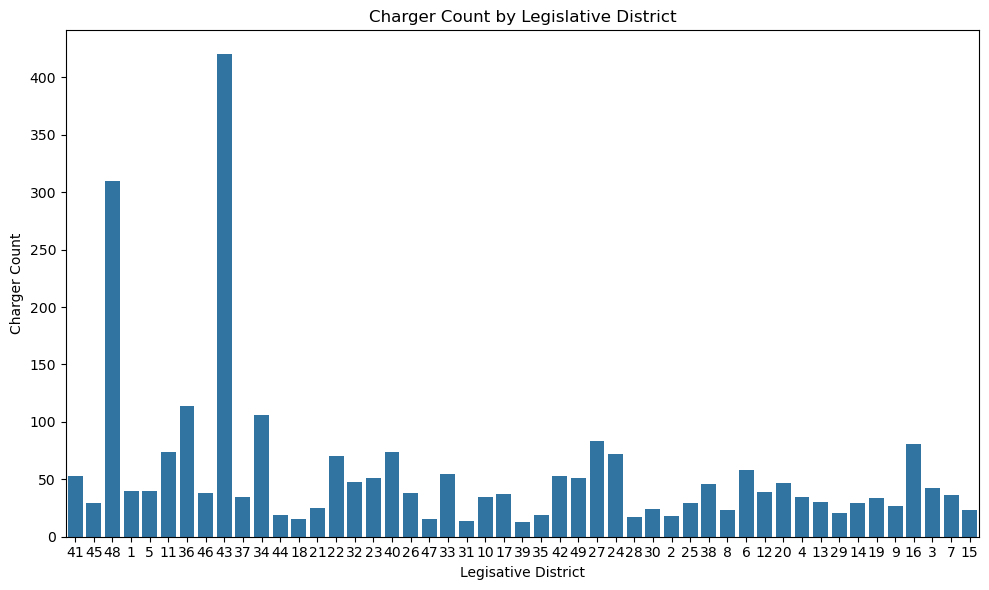

In [108]:
# Charger Count by Legislative District

plt.figure(figsize=(10,6))

# sns.countplot(data=charger, x='legislative_district_upper', order=order_ld)
sns.barplot(data=ev_merged, x='legislative_district', y='charger_count', order=order_ld)

plt.title('Charger Count by Legislative District')
plt.xlabel('Legisative District')
plt.ylabel('Charger Count')
plt.tight_layout()
plt.show();

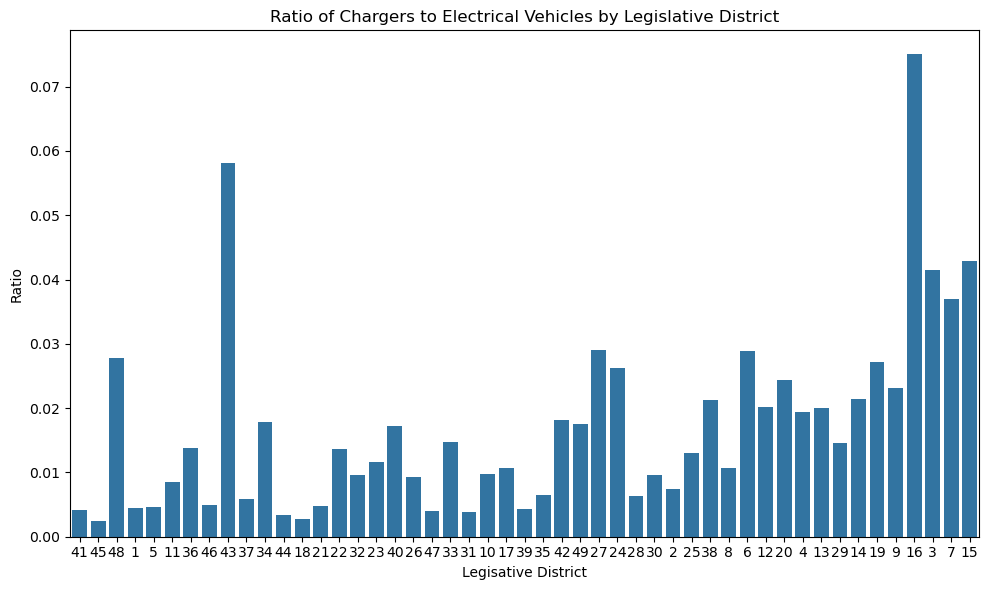

In [111]:
# Ratio of Chargers to Electrical Vehicles by Legislative District

# ev_count = ev_elec['legislative_district'].value_counts()
# charger_count = charger['legislative_district_upper'].value_counts()
# ratio = charger_count / ev_count

plt.figure(figsize=(10,6))

# sns.barplot(x=ratio.index, y=ratio.values, order=order_ld)
ev_merged['charger_ev_ratio'] = ev_merged['charger_count'] / ev_merged['ev_count']
sns.barplot(ev_merged, x='legislative_district', y='charger_ev_ratio', order=order_ld)

plt.title('Ratio of Chargers to Electrical Vehicles by Legislative District')
plt.xlabel('Legisative District')
plt.ylabel('Ratio')
plt.tight_layout()
plt.show();

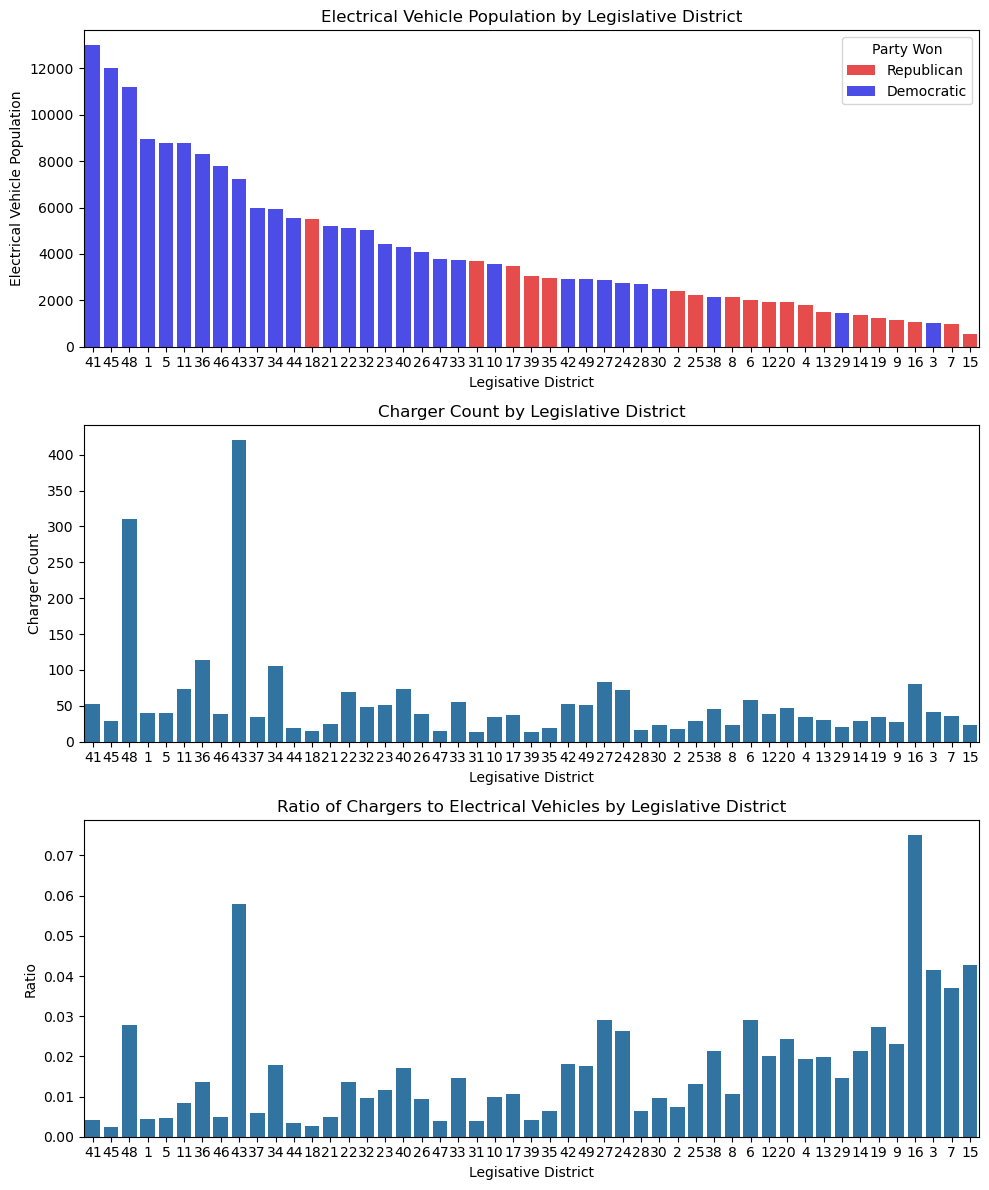

In [681]:
# electric vehicle and charging station

order = ev_elec['legislative_district'].value_counts().index

fig, axs = plt.subplots(3, figsize=(10, 12))

# plot 1: electric vehicle by ld
sns.countplot(data=ev_elec, x='legislative_district', 
              order=order, 
              hue='party_won_ld', palette=party_colors, ax=axs[0])
axs[0].set_title('Electrical Vehicle Population by Legislative District')
axs[0].set_xlabel('Legisative District')
axs[0].set_ylabel('Electrical Vehicle Population')
axs[0].legend(title='Party Won')

# plot 2: electric charging station by ld
sns.countplot(data=charger, x='legislative_district_upper', 
              order=order, 
              ax=axs[1])
axs[1].set_title('Charger Count by Legislative District')
axs[1].set_xlabel('Legisative District')
axs[1].set_ylabel('Charger Count')

# plot 3: EVs to fuel station ratio by ld
ev_count = ev_elec['legislative_district'].value_counts()
charger_count = charger['legislative_district_upper'].value_counts()
ratio = charger_count / ev_count
sns.barplot(x=ratio.index, y=ratio.values, order=order, ax=axs[2])
axs[2].set_title('Ratio of Chargers to Electrical Vehicles by Legislative District')
axs[2].set_xlabel('Legisative District')
axs[2].set_ylabel('Ratio')

plt.tight_layout()
plt.show()

## Washington Median Household Income in the Past 12 Months (In 2022 Inflation-adjusted Dollars)

Source: https://censusreporter.org/data/table/?table=B19013&geo_ids=610|04000US53#

- ACS 2022 5-year
- The American Community Survey (ACS) 2022 5-year estimates are a set of data collected between January 1, 2018 and December 31, 2022, that represent the characteristics of the population over that period. The ACS is a US Census Bureau initiative that collects demographic information on a nationwide basis. The 5-year estimates are the most reliable and comprehensive of the ACS period estimates, but are also the least current.
- Note:
    - Margin of Error: A number describing the statistical confidence in an estimate. When the margin of error is more than 10% of the estimate, Census Reporter recommends using caution when presenting the estimate. Know your wiggle-words.

In [258]:
# Washington Median Household Income in the Past 12 Months (ACS 2022 5-year)

house_income = pd.read_csv('./data/acs2022_5yr_B19013_61000US53043.csv')

# lower case
house_income.columns = ['_'.join(col.strip().lower().split()) for col in house_income.columns]
# change column names
house_income.rename(columns={'b19013001':'median_household_income'
                             , 'b19013001,_error':'margin_error'
                             , 'name':'legislative_district'
                            }
                    , inplace=True)

house_income['legislative_district'] = house_income['legislative_district'].apply(lambda x: x.strip().split()[-2][:-1])

# df = ev.copy() # copy
print_cols(house_income, 2)

(49, 4)


,geoid,legislative_district,median_household_income,margin_error
0,61000US53001,1,137250,4154
1,61000US53002,2,100417,2575


In [259]:
# Merge
# groupby legislative_district and merge

# median household income data
# add to the merged table
ev_merged = pd.merge(left=ev_merged, right=house_income, how='inner', on='legislative_district') # inner join

print_cols(ev_merged, 2)

(49, 12)


,legislative_district,ev_count,registered_voters,ballots_cast,%_turnout,patty_murray,tiffany_smiley,party_won,charger_count,geoid,median_household_income,margin_error
0,41,12994,98278,65840,0.6699,45730,19526,Democratic,53,61000US53041,176908,4036
1,45,12003,96577,67381,0.6977,46385,20531,Democratic,29,61000US53045,162491,5810


In [137]:
ev_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   legislative_district     49 non-null     object 
 1   ev_count                 49 non-null     int64  
 2   registered_voters        49 non-null     int64  
 3   ballots_cast             49 non-null     int64  
 4   %_turnout                49 non-null     float64
 5   patty_murray             49 non-null     int64  
 6   tiffany_smiley           49 non-null     int64  
 7   party_won                49 non-null     object 
 8   charger_count            49 non-null     int64  
 9   charger_ev_ratio         49 non-null     float64
 10  geoid                    49 non-null     object 
 11  median_household_income  49 non-null     int64  
 12  margin_error             49 non-null     int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 5.1+ KB


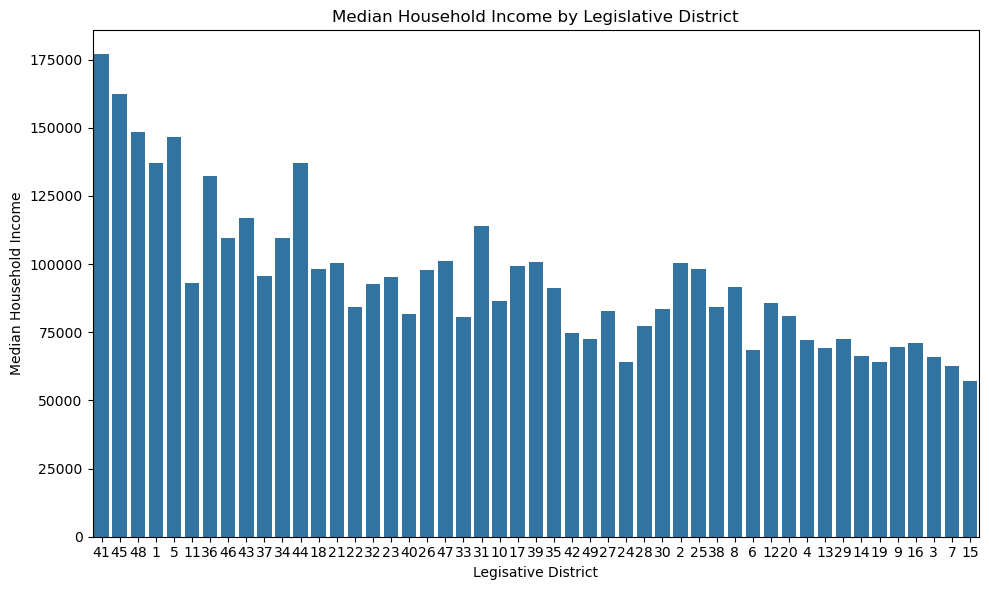

In [128]:
# Median Household Income by Legislative District

plt.figure(figsize=(10,6))

sns.barplot(data=ev_merged, x='legislative_district', y='median_household_income', order=order_ld)

plt.title('Median Household Income by Legislative District')
plt.xlabel('Legisative District')
plt.ylabel('Median Household Income')
plt.tight_layout()
plt.show();

## Washington State Legislative Districts 2022

Source: Washington Geospatial Open Data Portal
- https://geo.wa.gov/datasets/c2b31e7e2b6f464a92d1bed7ab1d7539_0/explore?location=47.056733%2C-120.812244%2C7.15

Description:
- Washington Legislative Districts 2022, as amended by adoption of HCR 4407 on February 8th 2022. Made into law IAW RCW 44.05.
- Contains 49 features representing each of Washington States 49 Legislative Districts.
- Projected to NAD 1983 HARN Washington State Plane South US Feet

In [260]:
# Washington Median Household Income in the Past 12 Months (ACS 2022 5-year)

wa_ld = pd.read_csv('./data/Washington_State_Legislative_Districts_2022.csv'
                    , dtype={'DISTRICTN':'object'})
# filter columns
wa_ld = wa_ld.iloc[:, 3:]
# lower case
wa_ld.columns = ['_'.join(col.strip().lower().split()) for col in wa_ld.columns]

# change column names
wa_ld.rename(columns={'districtn':'legislative_district'}, inplace=True)

# df = ev.copy() # copy
print_cols(wa_ld, 2)

(49, 6)


,legislative_district,shape_leng,shape_le_1,shape_area,shape__area,shape__length
0,1,0.9726,"288,803.8621","1,508,508,716.2500","309,992,363.9766","130,939.0400"
1,2,4.1628,"1,177,644.3371","24,474,087,223.9000","4,869,923,443.3984","525,359.6063"


In [196]:
wa_ld.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   legislative_district  49 non-null     object 
 1   shape_leng            49 non-null     float64
 2   shape_le_1            49 non-null     float64
 3   shape_area            49 non-null     float64
 4   shape__area           49 non-null     float64
 5   shape__length         49 non-null     float64
dtypes: float64(5), object(1)
memory usage: 2.4+ KB


In [261]:
# Merge
# groupby legislative_district and merge

# median household income data
# add to the merged table
ev_merged = pd.merge(left=ev_merged, right=wa_ld, how='inner', on='legislative_district') # inner join

print_cols(ev_merged, 2)

(49, 17)


,legislative_district,ev_count,registered_voters,ballots_cast,%_turnout,patty_murray,tiffany_smiley,party_won,charger_count,geoid,median_household_income,margin_error,shape_leng,shape_le_1,shape_area,shape__area,shape__length
0,41,12994,98278,65840,0.6699,45730,19526,Democratic,53,61000US53041,176908,4036,1.0598,"306,763.8140","1,667,039,196.5100","340,035,312.1016","138,532.7913"
1,45,12003,96577,67381,0.6977,46385,20531,Democratic,29,61000US53045,162491,5810,1.4077,"409,524.5479","2,890,039,170.5800","592,170,747.9688","185,351.7548"


In [262]:
# Create additional features

ev_merged['charger_density'] = ev_merged['charger_count'] / ev_merged['shape_area']
ev_merged['charger_density_per_100'] = (ev_merged['charger_count'] / ev_merged['shape_area']) * 100
print_cols(ev_merged, 2)

(49, 19)


,legislative_district,ev_count,registered_voters,ballots_cast,%_turnout,patty_murray,tiffany_smiley,party_won,charger_count,geoid,median_household_income,margin_error,shape_leng,shape_le_1,shape_area,shape__area,shape__length,charger_density,charger_density_per_100
0,41,12994,98278,65840,0.6699,45730,19526,Democratic,53,61000US53041,176908,4036,1.0598,"306,763.8140","1,667,039,196.5100","340,035,312.1016","138,532.7913",0.0000,0.0000
1,45,12003,96577,67381,0.6977,46385,20531,Democratic,29,61000US53045,162491,5810,1.4077,"409,524.5479","2,890,039,170.5800","592,170,747.9688","185,351.7548",0.0000,0.0000


In [263]:
print_all(ev_merged)

(49, 19)


,legislative_district,ev_count,registered_voters,ballots_cast,%_turnout,patty_murray,tiffany_smiley,party_won,charger_count,geoid,median_household_income,margin_error,shape_leng,shape_le_1,shape_area,shape__area,shape__length,charger_density,charger_density_per_100
0,41,12994,98278,65840,0.6699,45730,19526,Democratic,53,61000US53041,176908,4036,1.0598,"306,763.8140","1,667,039,196.5100","340,035,312.1016","138,532.7913",0.0000,0.0000
1,45,12003,96577,67381,0.6977,46385,20531,Democratic,29,61000US53045,162491,5810,1.4077,"409,524.5479","2,890,039,170.5800","592,170,747.9688","185,351.7548",0.0000,0.0000
2,48,11184,77691,48517,0.6245,34182,13895,Democratic,310,61000US53048,148591,4968,0.6211,"181,706.8231","1,120,866,866.4200","229,235,801.0547","82,175.0423",0.0000,0.0000
3,1,8946,99789,69622,0.6977,48493,20631,Democratic,40,61000US53001,137250,4154,0.9726,"288,803.8621","1,508,508,716.2500","309,992,363.9766","130,939.0400",0.0000,0.0000
4,5,8787,102856,72315,0.7031,42500,29265,Democratic,40,61000US53005,146755,4687,2.7970,"792,624.7295","12,441,513,564.6000","2,521,039,713.1953","356,781.8883",0.0000,0.0000
5,11,8773,88238,48172,0.5459,32574,15187,Democratic,74,61000US53011,93041,3975,1.0877,"321,387.5563","1,155,206,128.0400","234,731,248.2812","144,888.1188",0.0000,0.0000
6,36,8297,108957,80747,0.7411,72147,8065,Democratic,114,61000US53036,132142,6579,0.4777,"144,962.4012","1,010,932,055.8100","206,888,463.6016","65,595.8883",0.0000,0.0000
7,46,7790,102432,72421,0.7070,64466,7399,Democratic,38,61000US53046,109561,4122,0.3950,"116,774.9155","602,917,153.6320","123,533,221.6953","52,859.8212",0.0000,0.0000
8,43,7236,94330,64123,0.6798,58215,5473,Democratic,420,61000US53043,117067,3304,0.4943,"139,746.1338","449,414,058.6990","91,884,333.4688","63,167.4328",0.0000,0.0001
9,37,5994,100999,61077,0.6047,54661,5948,Democratic,35,61000US53037,95794,4126,0.5018,"154,424.1905","678,479,678.4510","138,282,034.4609","69,737.0951",0.0000,0.0000


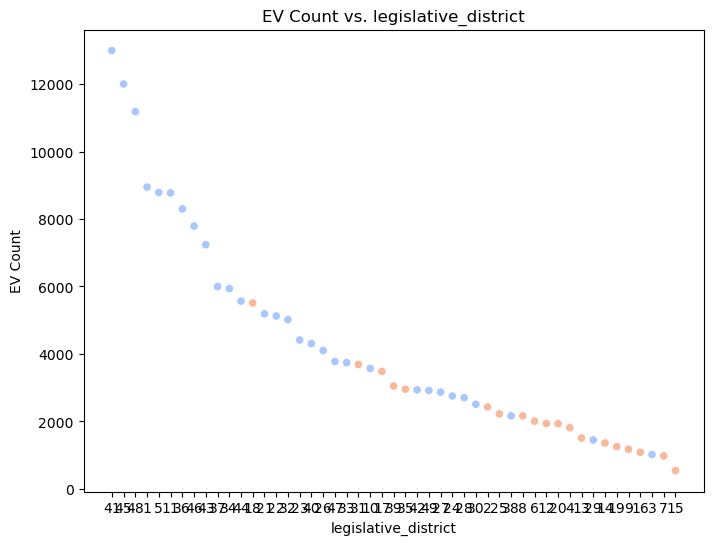

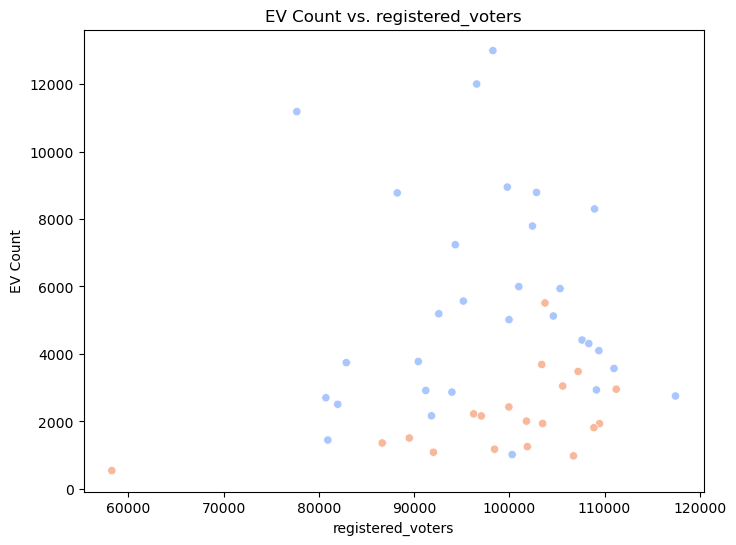

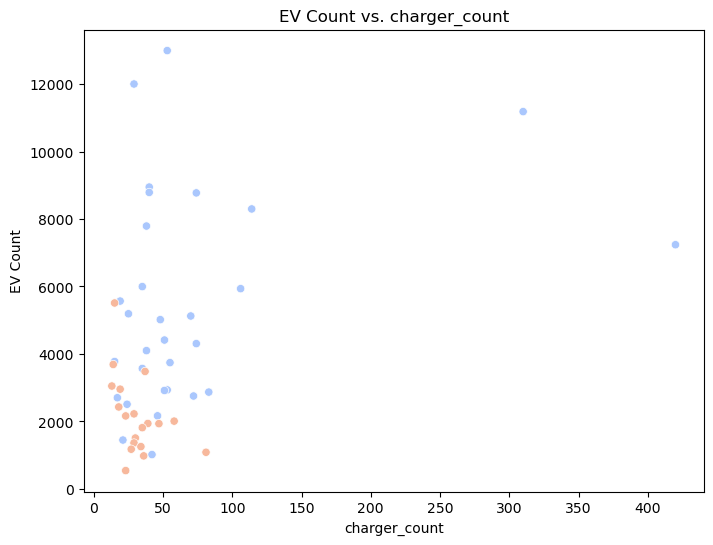

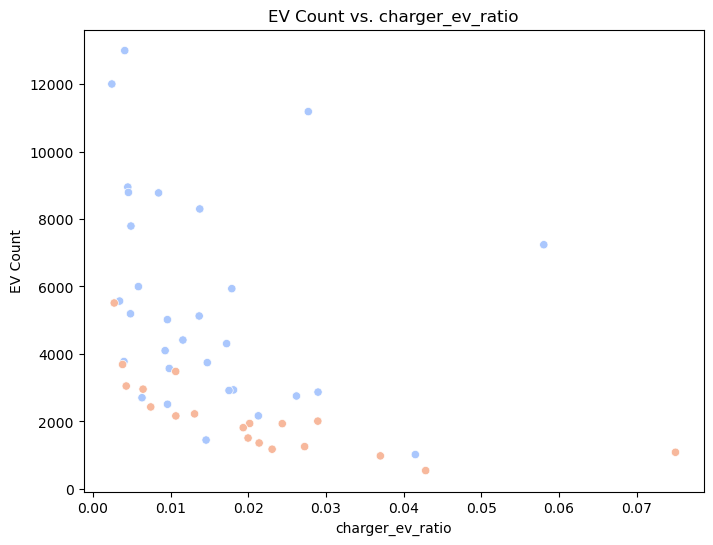

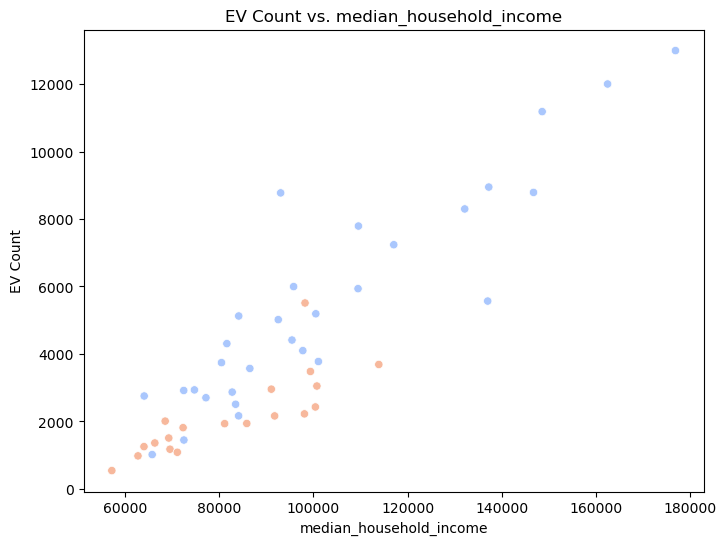

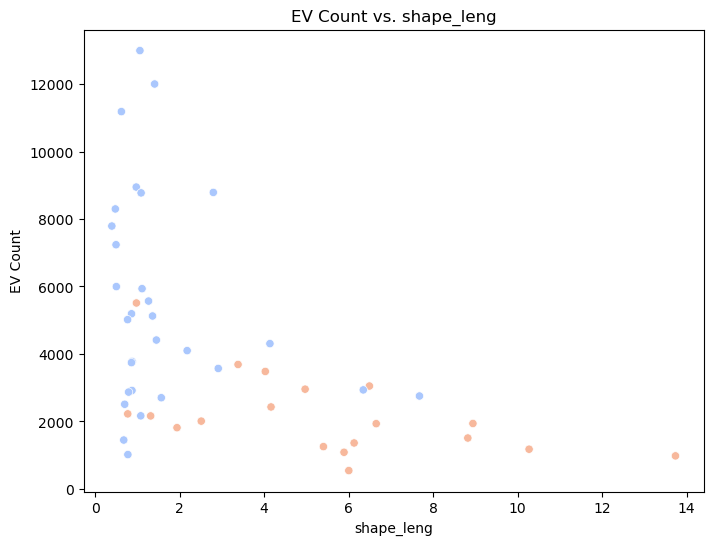

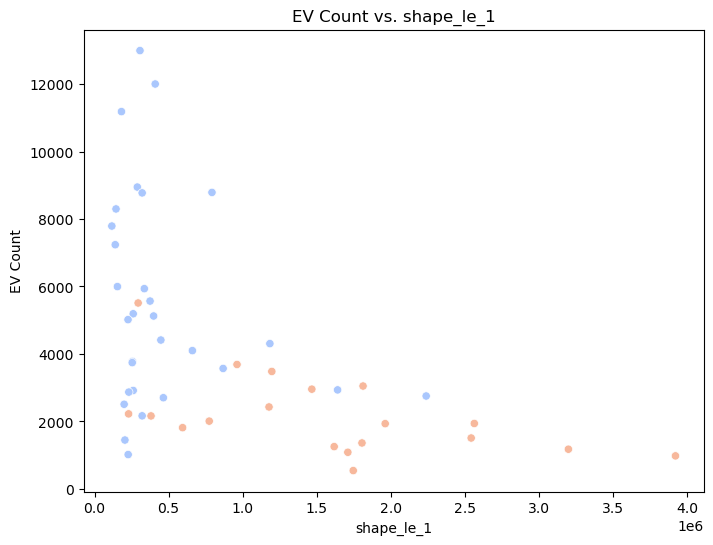

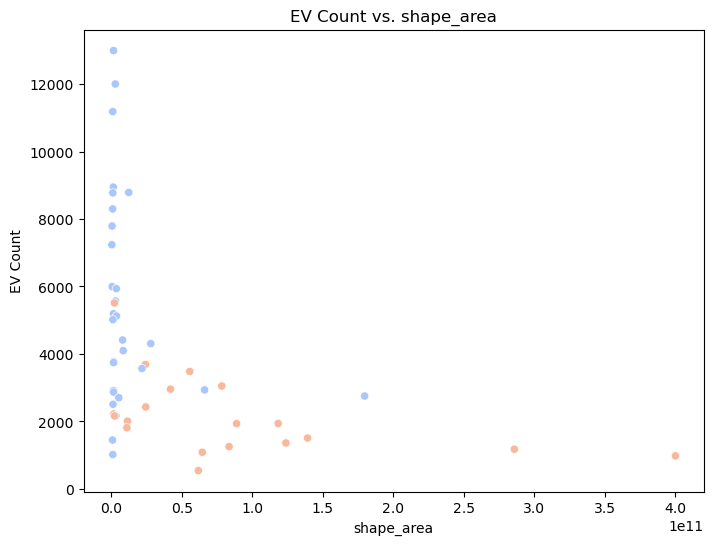

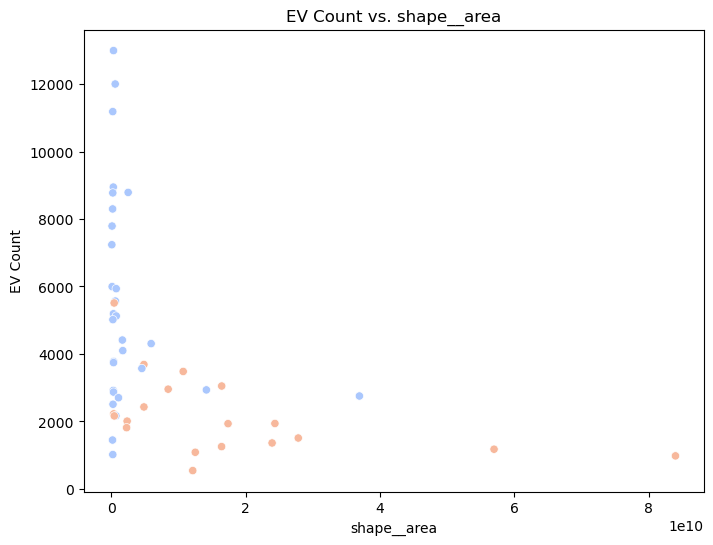

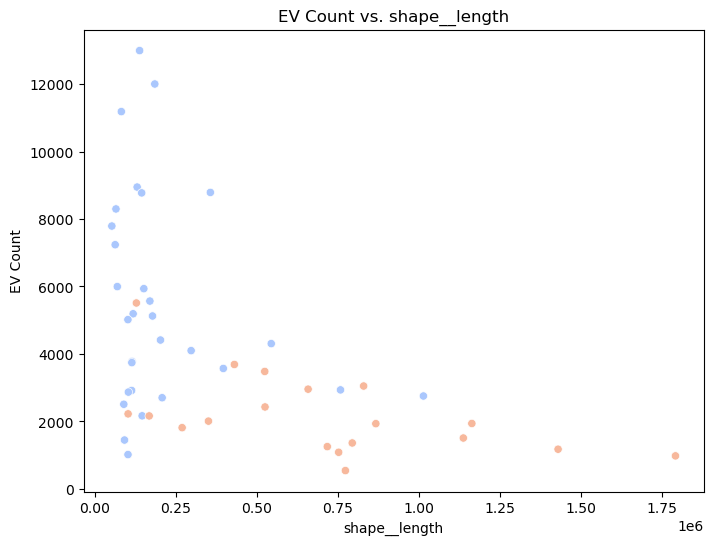

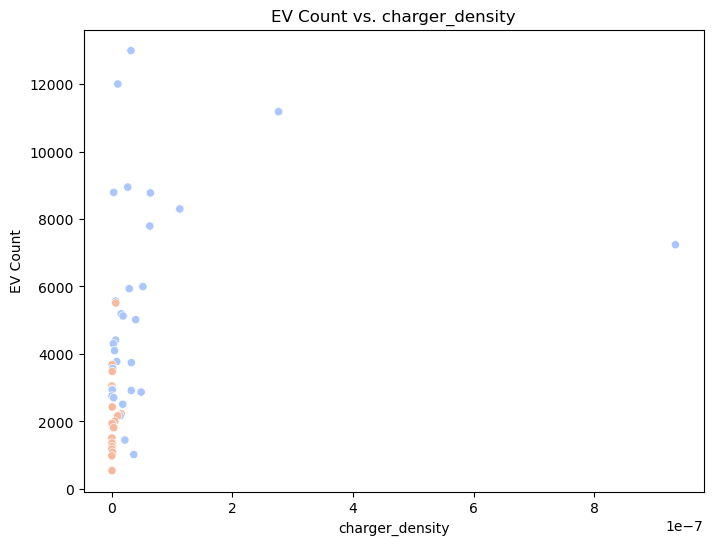

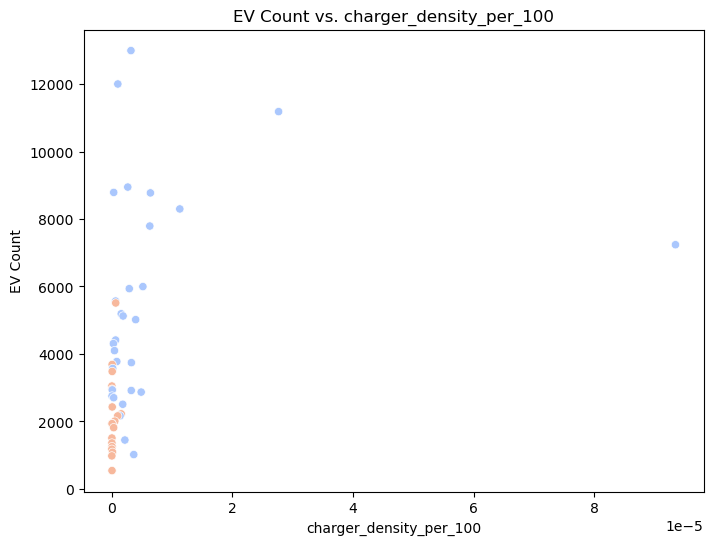

In [236]:
# Check which feature has correlation with EV count

excluded_cols = ['ballots_cast', '%_turnout', 'patty_murray', 'tiffany_smiley', 'geoid', 'margin_error', 'party_won', 'party_won_encoded']
key_cols = [col for col in ev_merged.columns if col not in excluded_cols + ['ev_count']]

# Scatter plot each feature vs. ev count
for col in key_cols:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=ev_merged, x=col, y='ev_count', hue='party_won', palette='coolwarm', legend=False)
    plt.title(f'EV Count vs. {col}')
    plt.xlabel(col)
    plt.ylabel('EV Count')
    plt.show()

- Some features seem to have outliers
    - Especially charing station related cols
- Might try to conduct scaling

## Voter Demographics Tables by legislative district
- Source: https://www.sos.wa.gov/elections/data-research/election-data-and-maps/reports-data-and-statistics/voter-demographics

In [ ]:
# Voter Demographics Tables by legislative district
# Source: https://www.sos.wa.gov/elections/data-research/election-data-and-maps/reports-data-and-statistics/voter-demographics
voters_age = pd.read_excel('data_raw/Voter Demographics Tables.xlsx', sheet_name='Age and Leg District', header=[0], nrows=49)
voters_age.columns = ['_'.join(col.strip().lower().split()) for col in voters_age.columns] # lower columns
voters_age.rename(columns={
    '18-24':'voters_18_24',
    '25-34':'voters_25_34',
    '35-44':'voters_35_44',
    '45-54':'voters_45_54',
    '55-64':'voters_55_64',
    '65_and_over':'voters_over_65',
    'total':'total_active_voters'
}, inplace=True) # rename columns
voters_age['legislative_district'] = voters_age['legislative_district'].astype(str).str.strip() # change dtype

In [ ]:
# Merge
ev_merged = pd.merge(left=ev_merged, right=voters_age, how='inner', on='legislative_district') # inner join

# Preprocessing Merged Data

further preprocessing before visualization and modeling
- encoding/scaling
- feature engineering

In [16]:
# Features creation & scaling

# Rename vote counts columns
ev_merged.rename(columns={'patty_murray':'dem_votes',
                          'tiffany_smiley':'rep_votes'},
                 inplace=True)

# Add charger density/ratio related variables
# ev_merged['charger_density_per_100'] = (ev_merged['charger_count'] / ev_merged['shape_area']) * 100
ev_merged['charger_density'] = ev_merged['charger_count'] / ev_merged['shape_area']
ev_merged['charger_density__area'] = ev_merged['charger_count'] / ev_merged['shape__area']
ev_merged['charger_density_leng'] = ev_merged['charger_count'] / ev_merged['shape_leng']
ev_merged['charger_density_le_1'] = ev_merged['charger_count'] / ev_merged['shape_le_1']
ev_merged['charger_density__length'] = ev_merged['charger_count'] / ev_merged['shape__length']
ev_merged['charger_per_voter_total'] = ev_merged['charger_count'] / ev_merged['total_active_voters']
ev_merged['charger_per_voter_18_24'] = ev_merged['charger_count'] / ev_merged['voters_18_24']
ev_merged['charger_per_voter_25_34'] = ev_merged['charger_count'] / ev_merged['voters_25_34']
ev_merged['charger_per_voter_35_44'] = ev_merged['charger_count'] / ev_merged['voters_35_44']
ev_merged['charger_per_voter_45_54'] = ev_merged['charger_count'] / ev_merged['voters_45_54']
ev_merged['charger_per_voter_55_64'] = ev_merged['charger_count'] / ev_merged['voters_55_64']
ev_merged['charger_per_voter_over_65'] = ev_merged['charger_count'] / ev_merged['voters_over_65']

# Add ratio of chargers to electrical vehicles
ev_merged['charger_ev_ratio'] = ev_merged['charger_count'] / ev_merged['ev_count']

# Scaling the relevant columns
# scaler = RobustScaler()
# scaler = StandardScaler()
# scaler = MinMaxScaler()
# np.log1p # Log
# np.cbrt # Cube Root
# ev_merged['scaled_charger_count'] = scaler.fit_transform(ev_merged[['charger_count']])
# ev_merged['scaled_ev_count'] = scaler.fit_transform(ev_merged[['ev_count']])
# ev_merged['scaled_charger_ev_ratio'] = scaler.fit_transform(ev_merged[['charger_ev_ratio']])
# ev_merged['scaled_charger_density'] = scaler.fit_transform(ev_merged[['charger_density']])
ev_merged['transformed_ev_count'] = np.sqrt(ev_merged['ev_count']) # square root transformation
ev_merged['transformed_charger_count'] = np.sqrt(ev_merged['charger_count'])
ev_merged['transformed_charger_ev_ratio'] = np.sqrt(ev_merged['charger_ev_ratio'])
ev_merged['transformed_charger_density'] = np.sqrt(ev_merged['charger_density'])

print_cols(ev_merged, 2)

(49, 41)


,legislative_district,ev_count,registered_voters,ballots_cast,%_turnout,dem_votes,rep_votes,party_won,charger_count,geoid,median_household_income,margin_error,shape_leng,shape_le_1,shape_area,shape__area,shape__length,voters_18_24,voters_25_34,voters_35_44,voters_45_54,voters_55_64,voters_over_65,total_active_voters,charger_density,charger_density__area,charger_density_leng,charger_density_le_1,charger_density__length,charger_per_voter_total,charger_per_voter_18_24,charger_per_voter_25_34,charger_per_voter_35_44,charger_per_voter_45_54,charger_per_voter_55_64,charger_per_voter_over_65,charger_ev_ratio,transformed_ev_count,transformed_charger_count,transformed_charger_ev_ratio,transformed_charger_density
0,41,12994,98278,65840,0.6699,45730,19526,Democratic,53,61000US53041,176908,4036,1.0598,"306,763.8140","1,667,039,196.5100","340,035,312.1016","138,532.7913",12155,13133,14562,19484,17576,23704,100614,0.0000,0.0000,50.0099,0.0002,0.0004,0.0005,0.0044,0.0040,0.0036,0.0027,0.0030,0.0022,0.0041,113.9912,7.2801,0.0639,0.0002
1,45,12003,96577,67381,0.6977,46385,20531,Democratic,29,61000US53045,162491,5810,1.4077,"409,524.5479","2,890,039,170.5800","592,170,747.9688","185,351.7548",10756,13852,17273,19538,16140,22119,99678,0.0000,0.0000,20.6017,0.0001,0.0002,0.0003,0.0027,0.0021,0.0017,0.0015,0.0018,0.0013,0.0024,109.5582,5.3852,0.0492,0.0001


In [17]:
# Save the dataset
with open('data_processed/ev_merged.pickle', 'wb') as f:
    pickle.dump(ev_merged, f)

# with open('data_processed/ev_merged.pickle', 'rb') as f:
#     ev_merged = pickle.load(f)